## Problem Statement


### Business Context

The prices of the stocks of companies listed under a global exchange are influenced by a variety of factors, with the company's financial performance, innovations and collaborations, and market sentiment being factors that play a significant role. News and media reports can rapidly affect investor perceptions and, consequently, stock prices in the highly competitive financial industry. With the sheer volume of news and opinions from a wide variety of sources, investors and financial analysts often struggle to stay updated and accurately interpret its impact on the market. As a result, investment firms need sophisticated tools to analyze market sentiment and integrate this information into their investment strategies.

### Problem Definition

With an ever-rising number of news articles and opinions, an investment startup aims to leverage artificial intelligence to address the challenge of interpreting stock-related news and its impact on stock prices. They have collected historical daily news for a specific company listed under NASDAQ, along with data on its daily stock price and trade volumes.

As a member of the Data Science and AI team in the startup, you have been tasked with analyzing the data, developing an AI-driven sentiment analysis system that will automatically process and analyze news articles to gauge market sentiment, and summarizing the news at a weekly level to enhance the accuracy of their stock price predictions and optimize investment strategies. This will empower their financial analysts with actionable insights, leading to more informed investment decisions and improved client outcomes.

### Data Dictionary

* `Date` : The date the news was released
* `News` : The content of news articles that could potentially affect the company's stock price
* `Open` : The stock price (in \$) at the beginning of the day
* `High` : The highest stock price (in \$) reached during the day
* `Low` :  The lowest stock price (in \$) reached during the day
* `Close` : The adjusted stock price (in \$) at the end of the day
* `Volume` : The number of shares traded during the day
* `Label` : The sentiment polarity of the news content
    * 1: positive
    * 0: neutral
    * -1: negative

## Please read the instructions carefully before starting the project.

**Note**: If the free-tier GPU of Google Colab is not accessible (due to unavailability or exhaustion of daily limit or other reasons), the following steps can be taken:

1. Wait for 12-24 hours until the GPU is accessible again or the daily usage limits are reset.

2. Switch to a different Google account and resume working on the project from there.

3. Try using the CPU runtime:
    - To use the CPU runtime, click on *Runtime* => *Change runtime type* => *CPU* => *Save*
    - One can also click on the *Continue without GPU* option to switch to a CPU runtime (kindly refer to the snapshot below)
    - The instructions for running the code on the CPU are provided in the respective sections of the notebook.

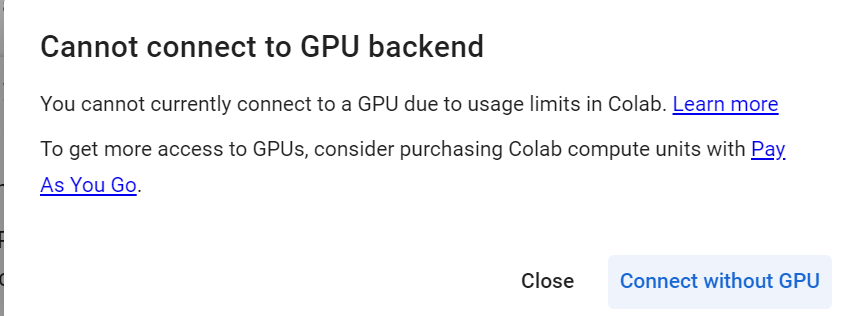

## Installing and Importing Necessary Libraries

In [ ]:
from prometheus_client import metrics
from sklearn.utils import class_weight
# installing the sentence-transformers and gensim libraries for word embeddings
!pip install -U sentence-transformers gensim transformers tqdm -q

In [2]:
# To manipulate and analyze data
import pandas as pd
import numpy as np

# To visualize data
import matplotlib.pyplot as plt
import seaborn as sns

# To used time-related functions
import time

# To parse JSON data
import json

# to load the natural language toolkit
import nltk
nltk.download('stopwords')    # loading the stopwords
# nltk.download('punkt')    # loading the punkt module used in tokenization
# nltk.download('omw-1.4')    # dependency for tokenization
nltk.download('wordnet')   # loading the wordnet module that is used in stemming


# To build, tune, and evaluate ML models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)
from xgboost import XGBClassifier


from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

# To load/create word embeddings
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

# To work with transformer models
import torch
from sentence_transformers import SentenceTransformer

# To implement progress bar related functionalities
from tqdm import tqdm
tqdm.pandas()

# To ignore unnecessary warnings
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/christophebuffard/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/christophebuffard/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Loading the dataset

In [3]:
stock_news = pd.read_csv("stock_news.csv")
df = stock_news.copy()

## Data Overview

In [4]:
df.shape

(349, 8)

In [5]:
df.head()

,Date,News,Open,High,Low,Close,Volume,Label
0,2019-01-02,The tech sector experienced a significant dec...,41.740002,42.244999,41.482498,40.246914,130672400,-1
1,2019-01-02,Apple lowered its fiscal Q1 revenue guidance ...,41.740002,42.244999,41.482498,40.246914,130672400,-1
2,2019-01-02,Apple cut its fiscal first quarter revenue fo...,41.740002,42.244999,41.482498,40.246914,130672400,-1
3,2019-01-02,This news article reports that yields on long...,41.740002,42.244999,41.482498,40.246914,130672400,-1
4,2019-01-02,Apple's revenue warning led to a decline in U...,41.740002,42.244999,41.482498,40.246914,130672400,-1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    349 non-null    object 
 1   News    349 non-null    object 
 2   Open    349 non-null    float64
 3   High    349 non-null    float64
 4   Low     349 non-null    float64
 5   Close   349 non-null    float64
 6   Volume  349 non-null    int64  
 7   Label   349 non-null    int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 21.9+ KB


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,349.0,4.622923e+01,6.442817e+00,3.756750e+01,4.174000e+01,4.597500e+01,5.070750e+01,6.681750e+01
High,349.0,4.670046e+01,6.507321e+00,3.781750e+01,4.224500e+01,4.602500e+01,5.085000e+01,6.706250e+01
Low,349.0,4.574539e+01,6.391976e+00,3.730500e+01,4.148250e+01,4.564000e+01,4.977750e+01,6.586250e+01
Close,349.0,4.492632e+01,6.398338e+00,3.625413e+01,4.024691e+01,4.459692e+01,4.911079e+01,6.480523e+01
Volume,349.0,1.289482e+08,4.317031e+07,4.544800e+07,1.032720e+08,1.156272e+08,1.511252e+08,2.444392e+08
Label,349.0,-5.444126e-02,7.151192e-01,-1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


In [8]:
df.columns.tolist()

['Date', 'News', 'Open', 'High', 'Low', 'Close', 'Volume', 'Label']

In [9]:
df.isnull().sum()

Date      0
News      0
Open      0
High      0
Low       0
Close     0
Volume    0
Label     0
dtype: int64

In [10]:
df.nunique()

Date       71
News      349
Open       70
High       70
Low        71
Close      71
Volume     71
Label       3
dtype: int64

In [11]:
df.duplicated().sum()

0

In [12]:
# Filter the DataFrame to show only duplicated rows
duplicated_rows = df[df.duplicated()]
print("\nDuplicated rows:")
print(duplicated_rows)


Duplicated rows:
Empty DataFrame
Columns: [Date, News, Open, High, Low, Close, Volume, Label]
Index: []


In [13]:
df.Date.info()

<class 'pandas.core.series.Series'>
RangeIndex: 349 entries, 0 to 348
Series name: Date
Non-Null Count  Dtype 
--------------  ----- 
349 non-null    object
dtypes: object(1)
memory usage: 2.9+ KB


In [14]:
df['Date'] = pd.to_datetime(df['Date'])

In [15]:
# Sort the data by date
df = df.sort_values('Date')

### Observation
* No missing value
* No duplicate data
* convert the Data column to a date/time format
* Sort the dataset around the date as it is clearly a time serie.

## Exploratory Data Analysis

### Univariate Analysis

* Distribution of individual variables
* Compute and check the distribution of the length of news content

In [16]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    title = "Observation on " + feature
    plt.suptitle(title, fontsize=16)
    plt.show()  # show the plot

In [17]:

label = {
    1: 'positive',
    0: 'neutral',
    -1: 'negative'
}
df['Label'] = df['Label'].map(label)

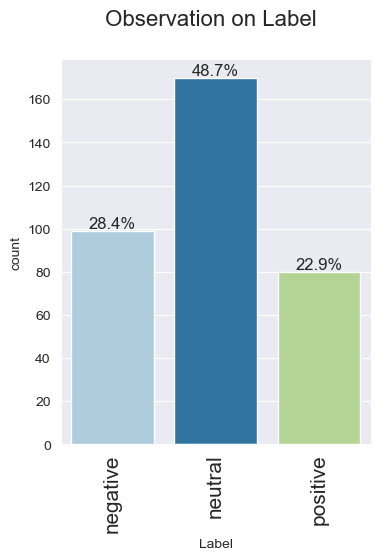

In [18]:
#category_columns = df.select_dtypes("object").columns
category_columns = ['Label']
for i in category_columns:
    labeled_barplot(df, i, perc=True)

In [19]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a triangle will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram
    # Add the title to the figure
    title = "Observation on " + feature
    f2.suptitle(title, fontsize=16)
    plt.show()

In [20]:
### Function to plot distributions

def distribution_plot_wrt_target(data, predictor, target):
    """
    Print the distribution of the predictor per target, and for the predictor
    :param data: dataframe
    :param predictor: the predictor we want to print the distribution of
    :param target: the target we want to print
    """
    target_uniq = data[target].unique()
    n = len(target_uniq)  # Number of unique target values
    fig, axs = plt.subplots(1, n, figsize=(18, 6))  # Creates a 1xn grid of subplots

    for i in range(n):
        axs[i].set_title("Distribution of " + predictor + " for target " + target_uniq[i])
        sns.histplot(
            data=data[data[target] == target_uniq[i]],
            x=predictor,
            kde=True,
            ax=axs[i],
            color="teal",
        )
    plt.tight_layout()
    plt.show()


In [21]:
# function to plot stacked bar chart

def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """

    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 1, 5))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    title = "Target: " + target + " vs. Predictor: " + predictor
    plt.title(title)
    plt.show()

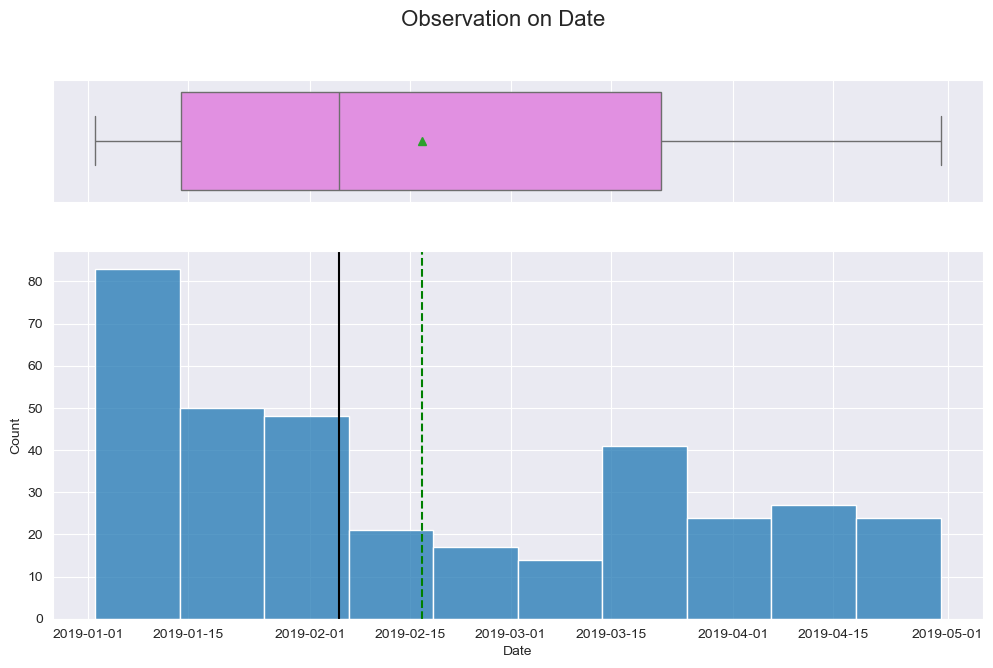

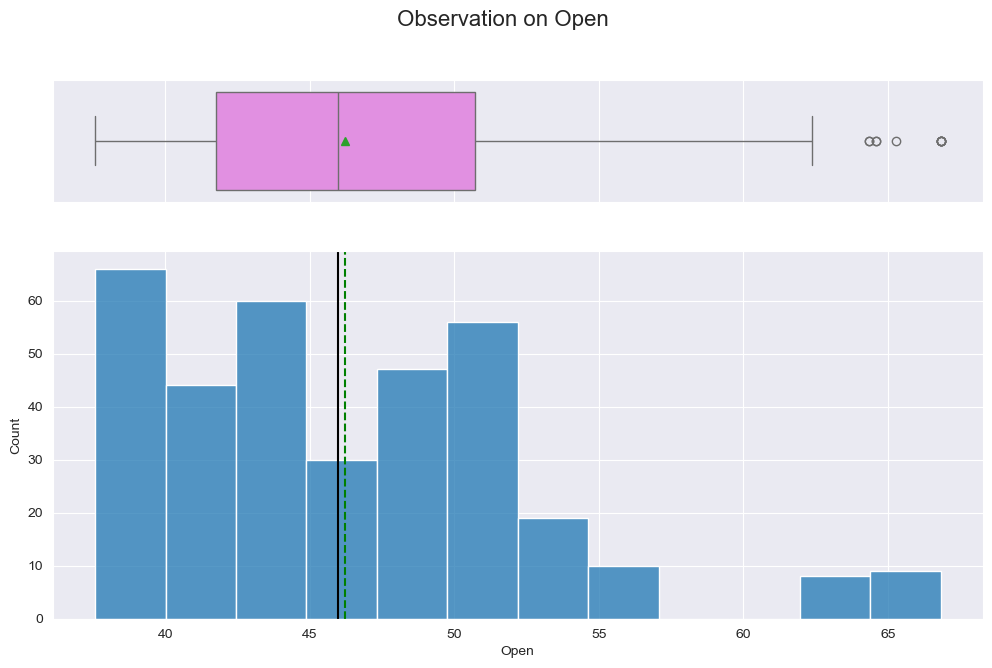

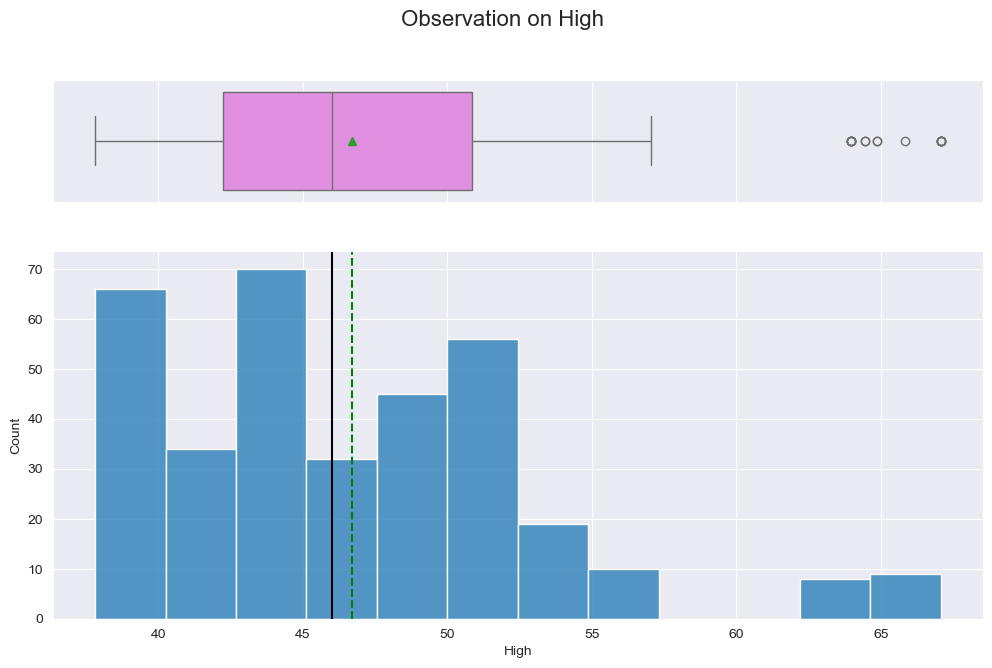

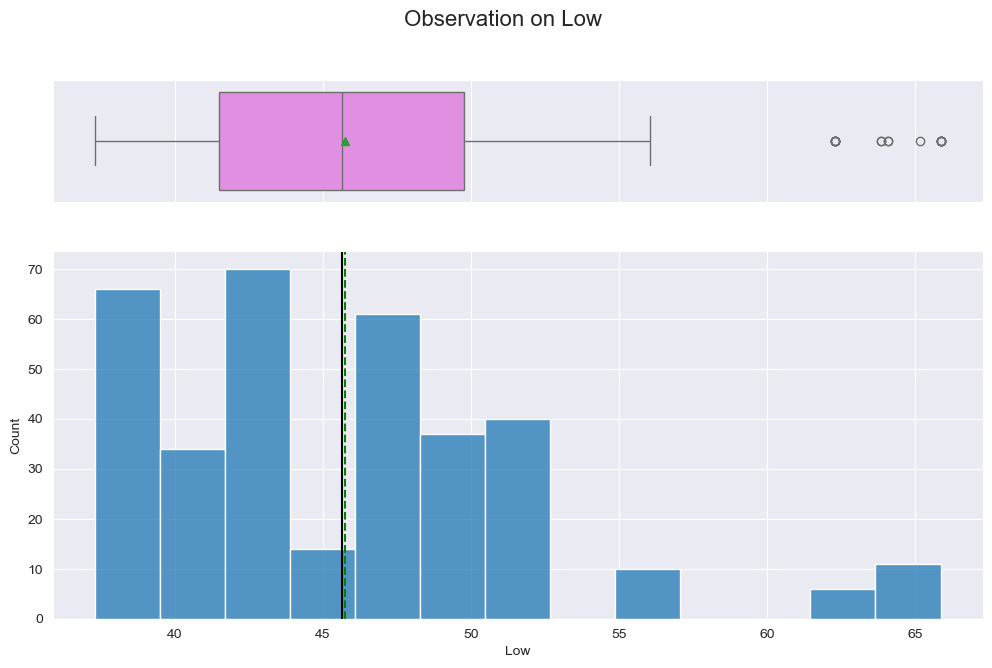

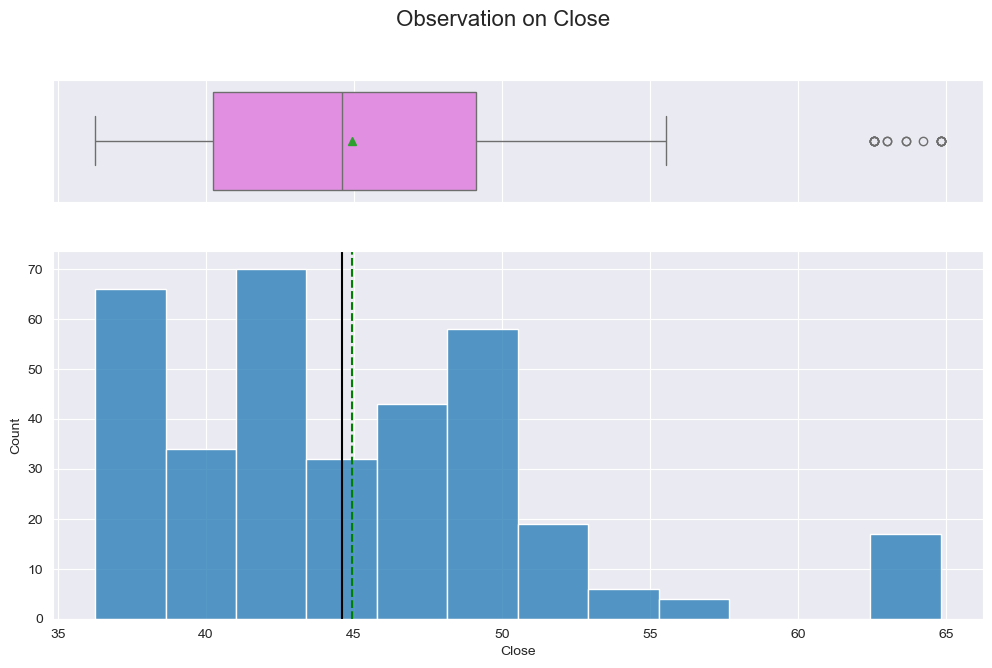

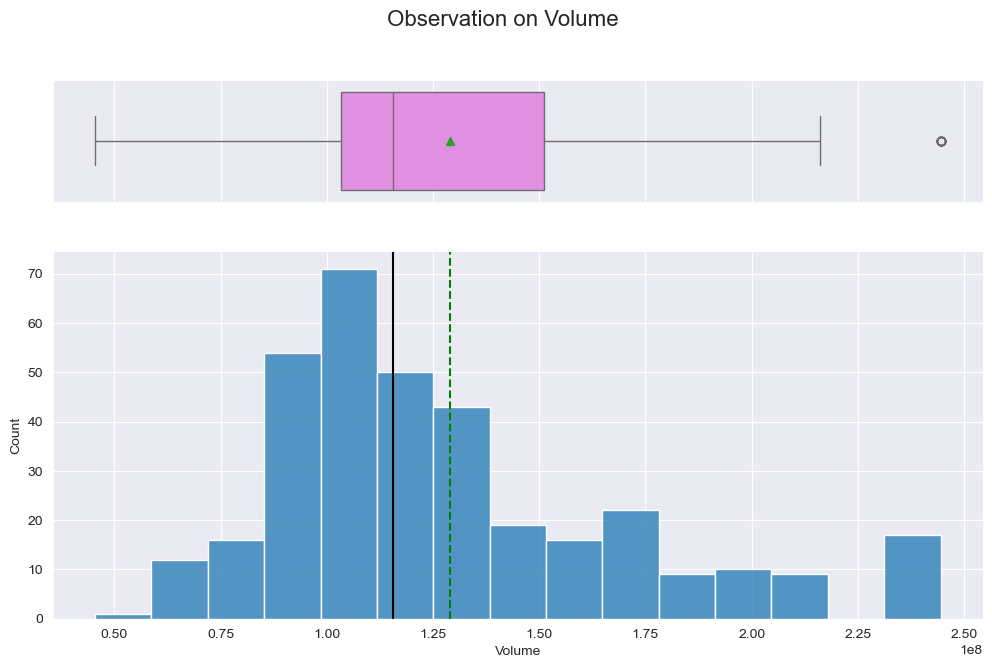

In [22]:
non_category_columns = df.select_dtypes(exclude=["object"]).columns
for i in non_category_columns:
    histogram_boxplot(df, i)

### Bivariate Analysis

* Correlation
* Sentiment Polarity vs Price
* Date vs Price

**Note**: The above points are listed to provide guidance on how to approach bivariate analysis. Analysis has to be done beyond the above listed points to get maximum scores.

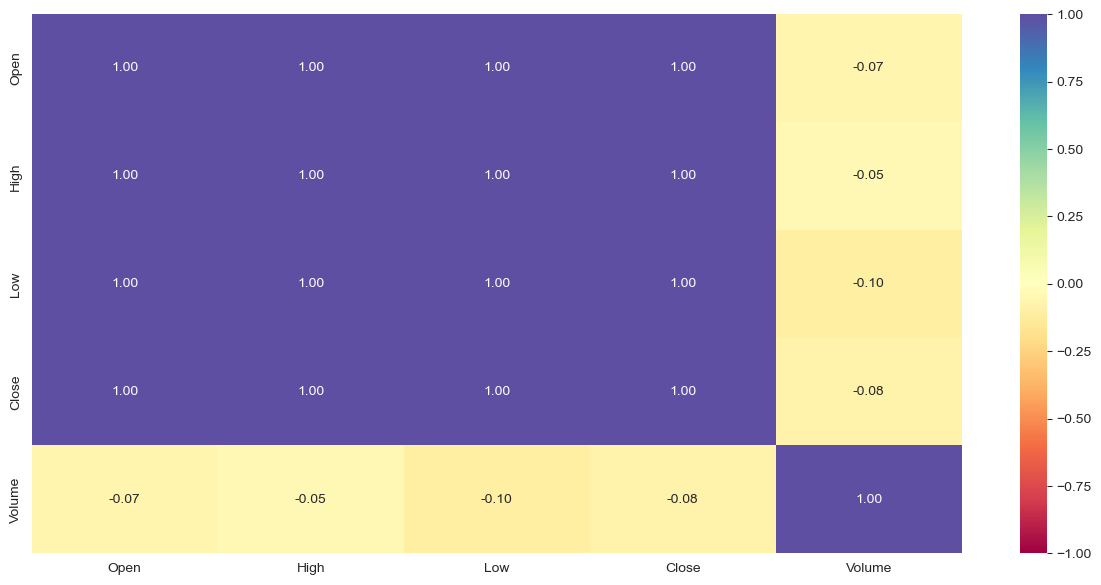

In [23]:
dataCorr = df[df.select_dtypes(include='number').columns.tolist()]
plt.figure(figsize=(15, 7))
sns.heatmap(dataCorr.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

#### Observation
We see that the following data:
* Open
* High
* Low
* Close

Are highly correlated.


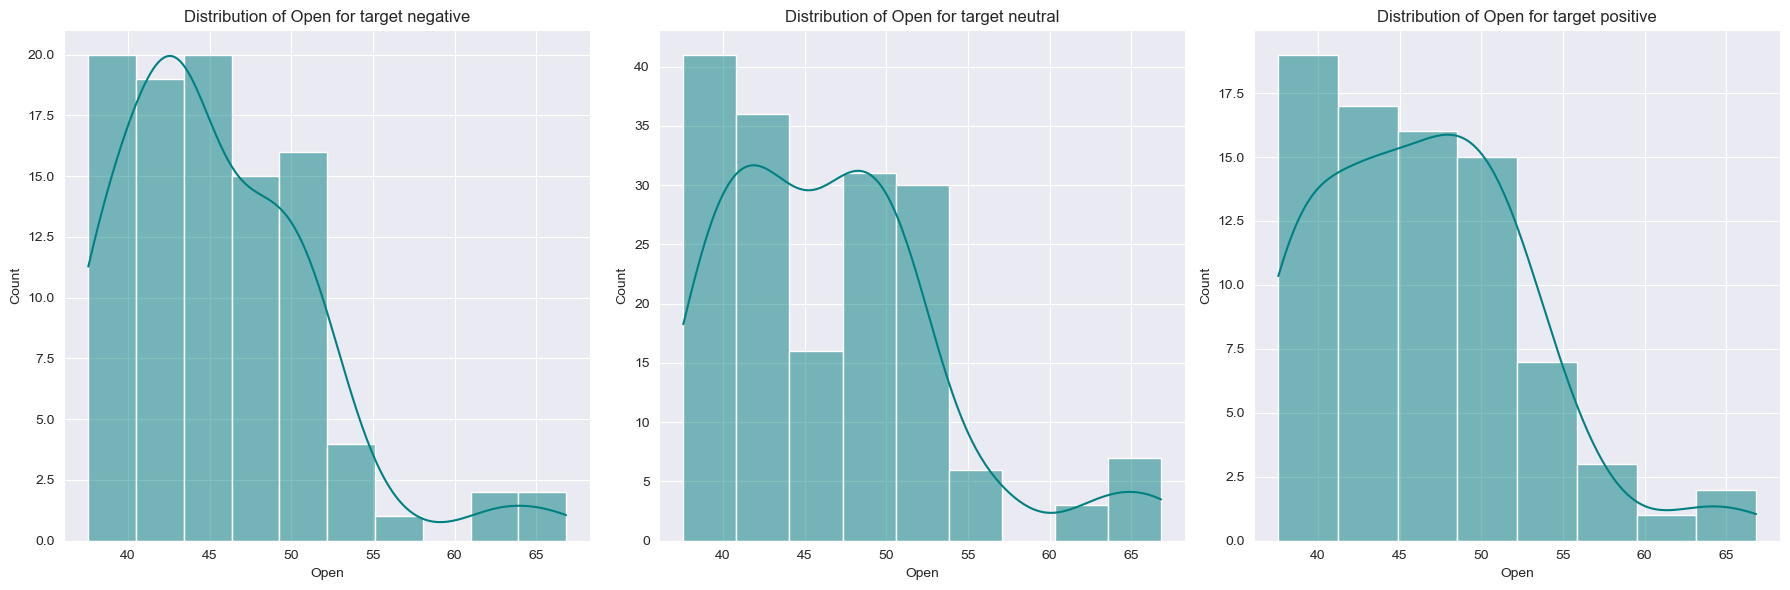

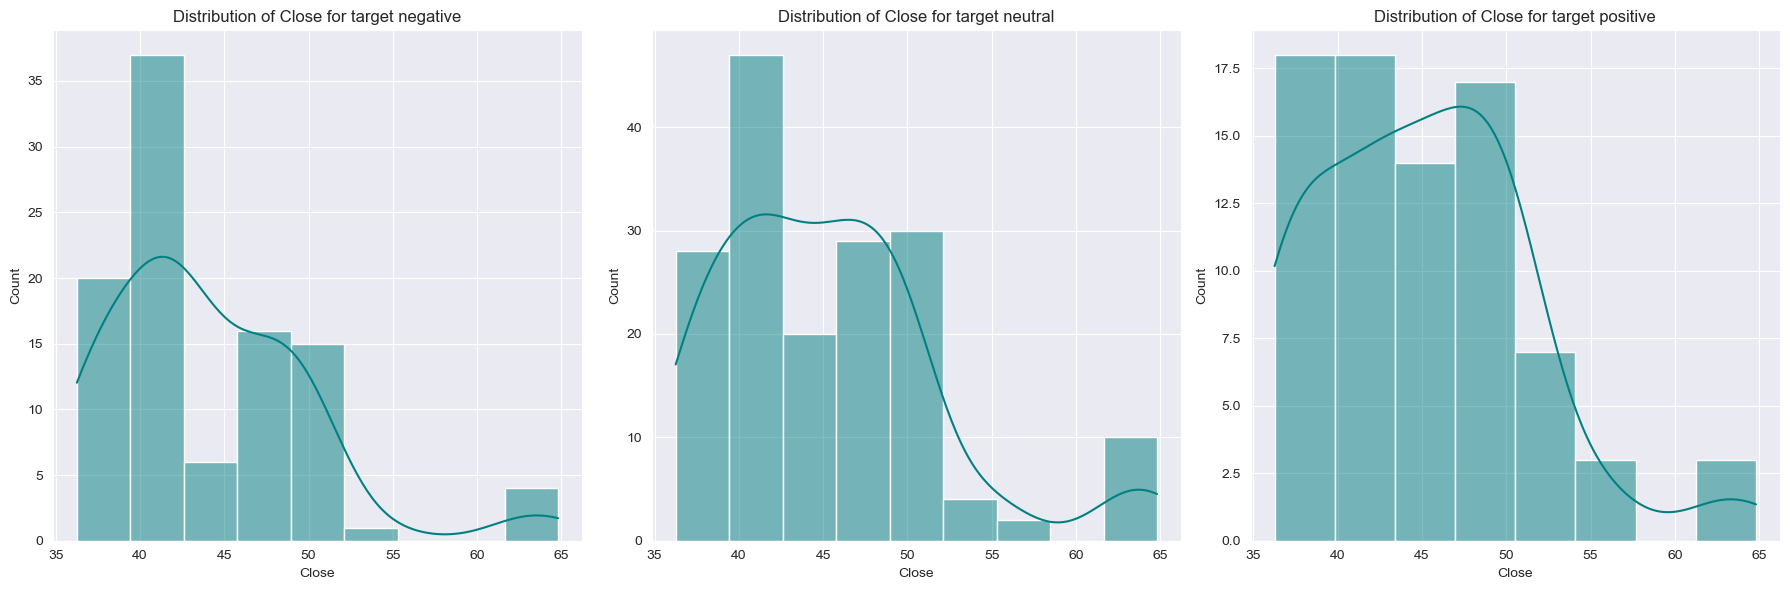

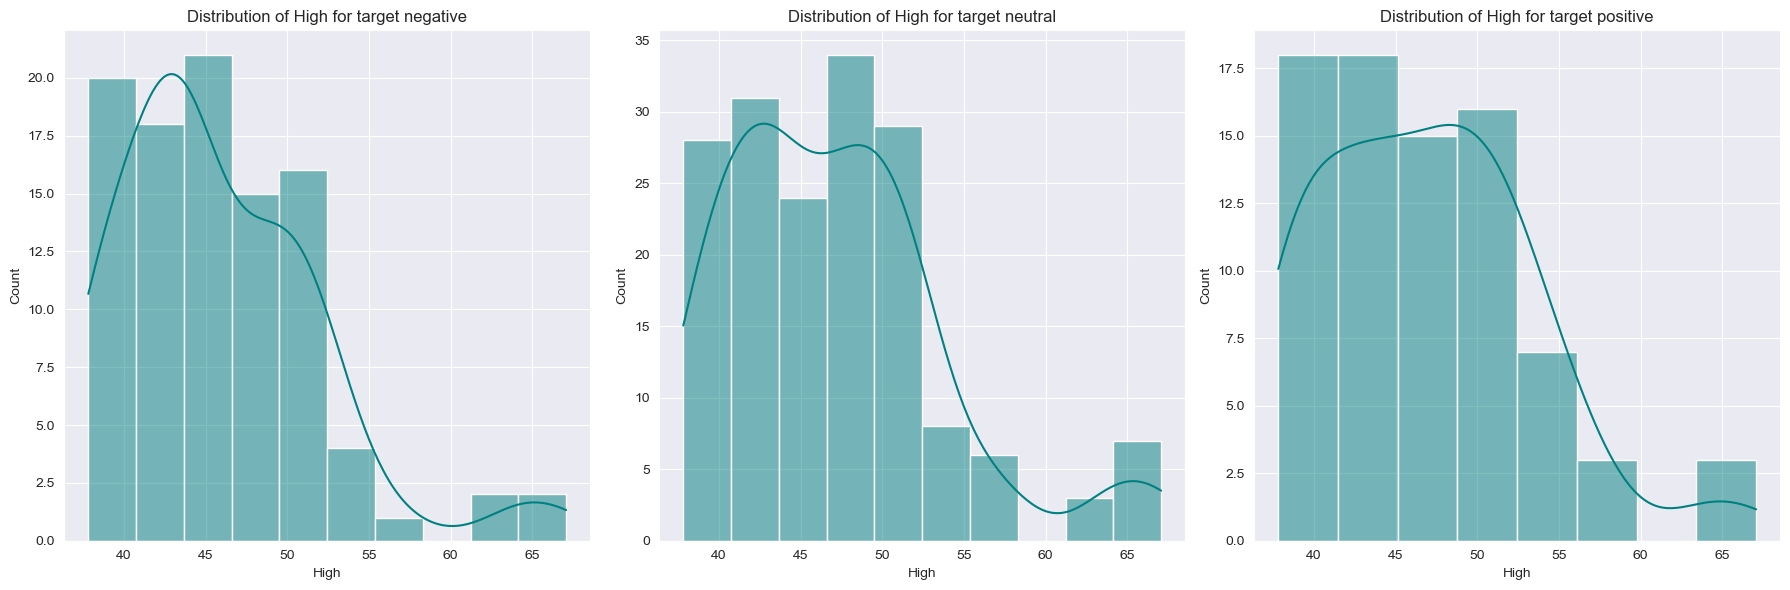

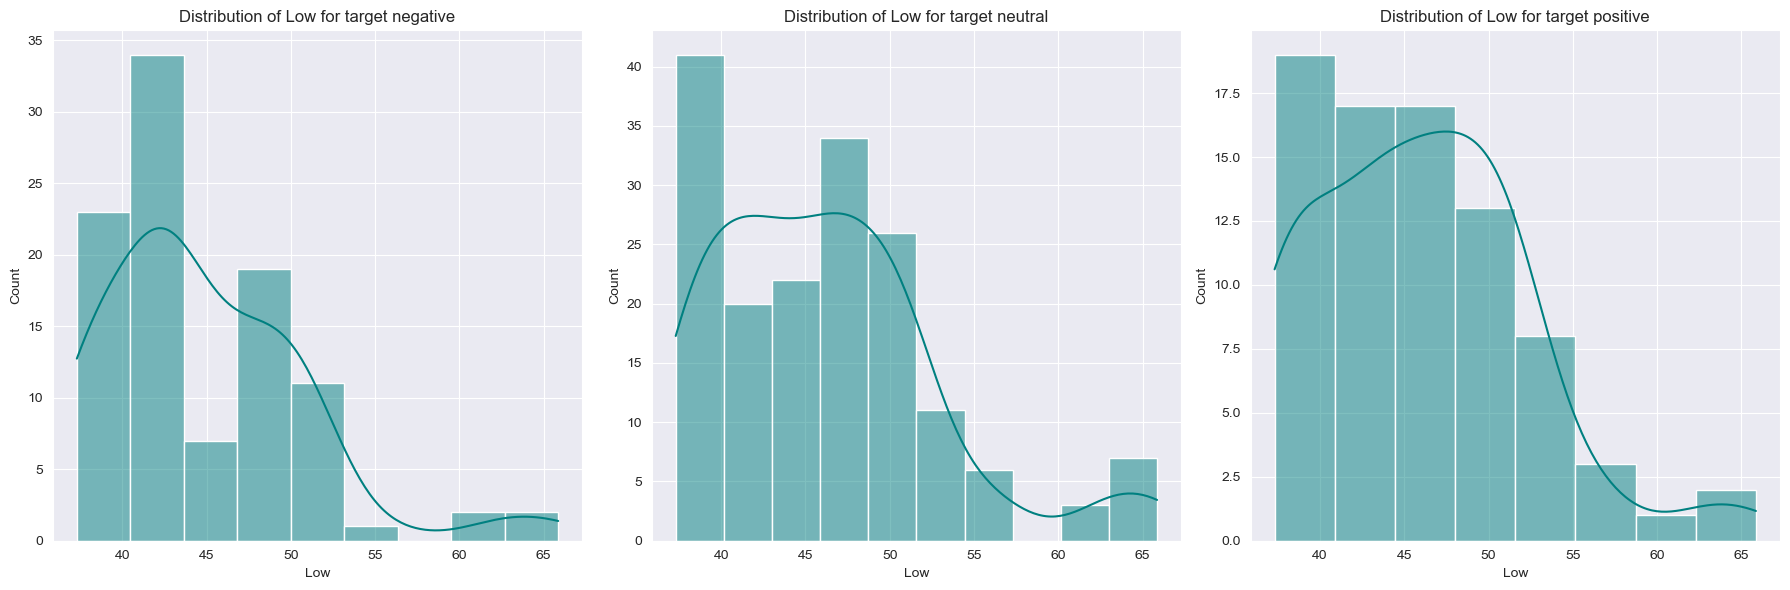

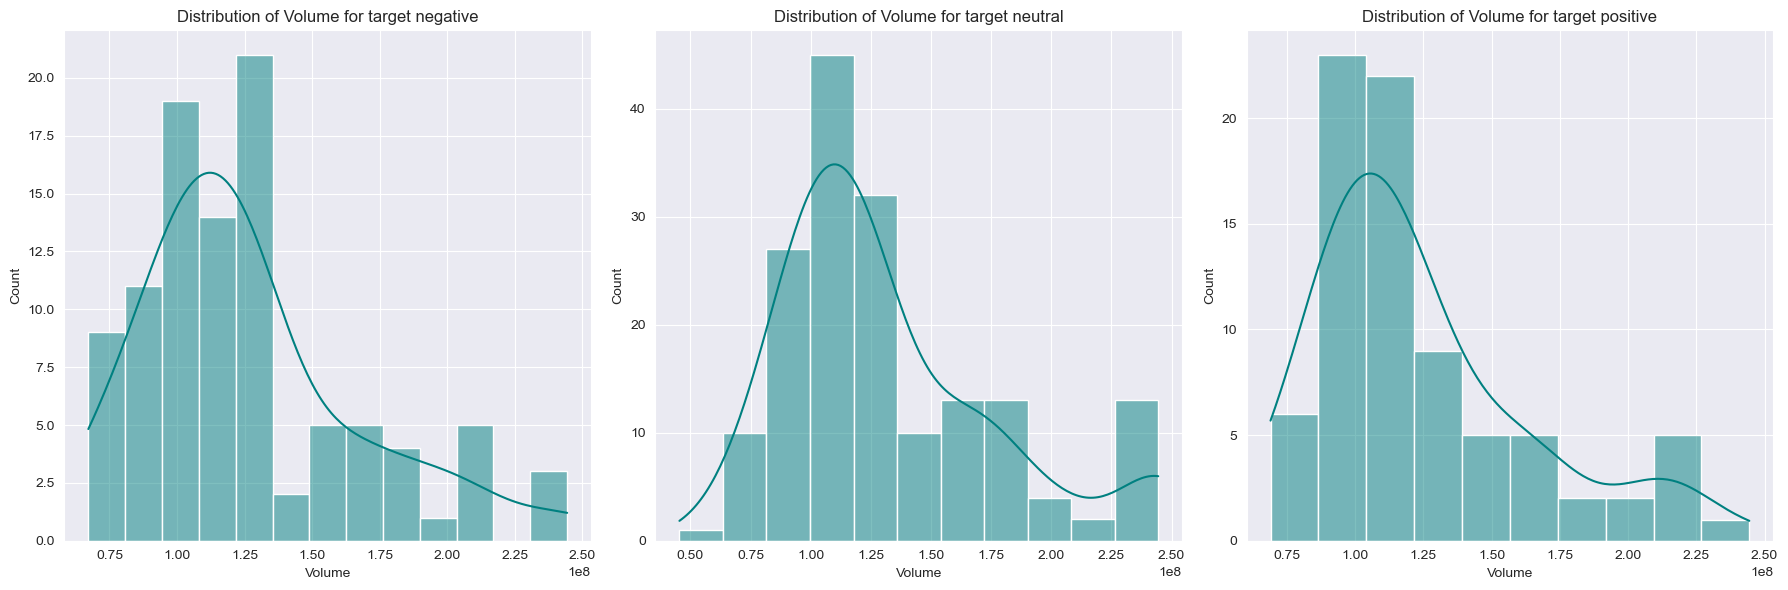

In [24]:
non_category_columns = ['Open', 'Close', 'High', 'Low', 'Volume']
for i in non_category_columns:
    distribution_plot_wrt_target(df, i, 'Label')

Label      negative  neutral  positive  All
Open                                       
All              99      170        80  349
53.474998         2        2         5    9
39.102501         2        4         4   10
43.57            14       10         4   28
37.567501         4        3         4   11
...             ...      ...       ...  ...
43.427502         1        0         0    1
48.3125           0        1         0    1
45.5625           0        2         0    2
46.557499         1        1         0    2
38.549999         0        2         0    2

[71 rows x 4 columns]
------------------------------------------------------------------------------------------------------------------------


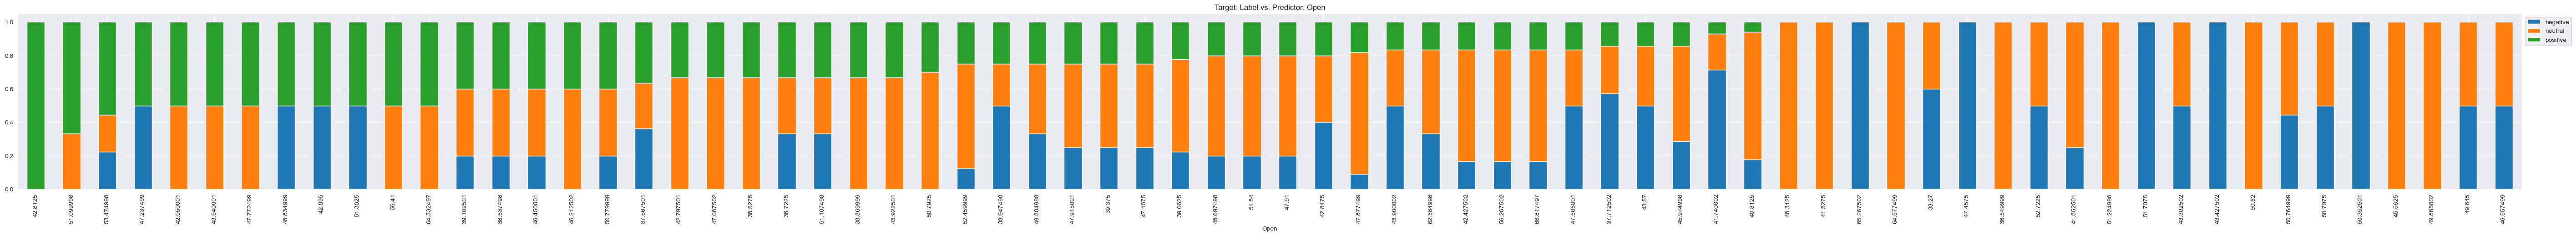

Label      negative  neutral  positive  All
Close                                      
All              99      170        80  349
50.787209         2        2         5    9
36.996128         4        3         4   11
37.051727         2        4         4   10
42.470604        14       10         4   28
...             ...      ...       ...  ...
41.45842          1        4         0    5
49.398319         1        0         0    1
47.417465         0        1         0    1
48.70879          4        5         0    9
49.589897         0        1         0    1

[72 rows x 4 columns]
------------------------------------------------------------------------------------------------------------------------


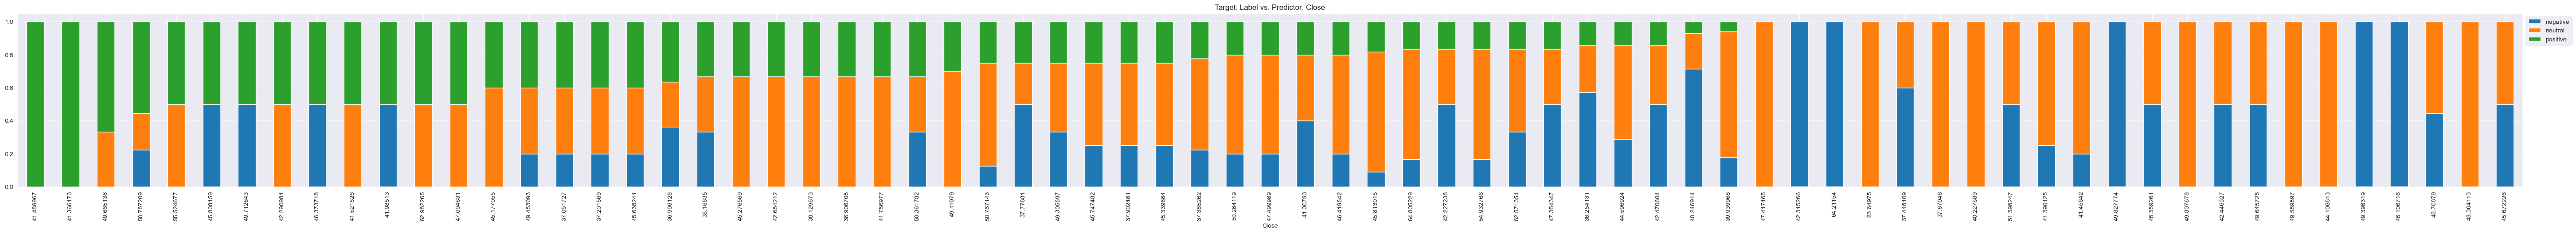

Label      negative  neutral  positive  All
High                                       
All              99      170        80  349
54.5075           2        2         5    9
38.3475           4        3         4   11
43.787498        14       10         4   28
39.182499         2        4         4   10
...             ...      ...       ...  ...
43.75             1        1         0    2
43.825001         1        0         0    1
45.825001         0        2         0    2
47.52             2        0         0    2
42.915001         1        3         0    4

[71 rows x 4 columns]
------------------------------------------------------------------------------------------------------------------------


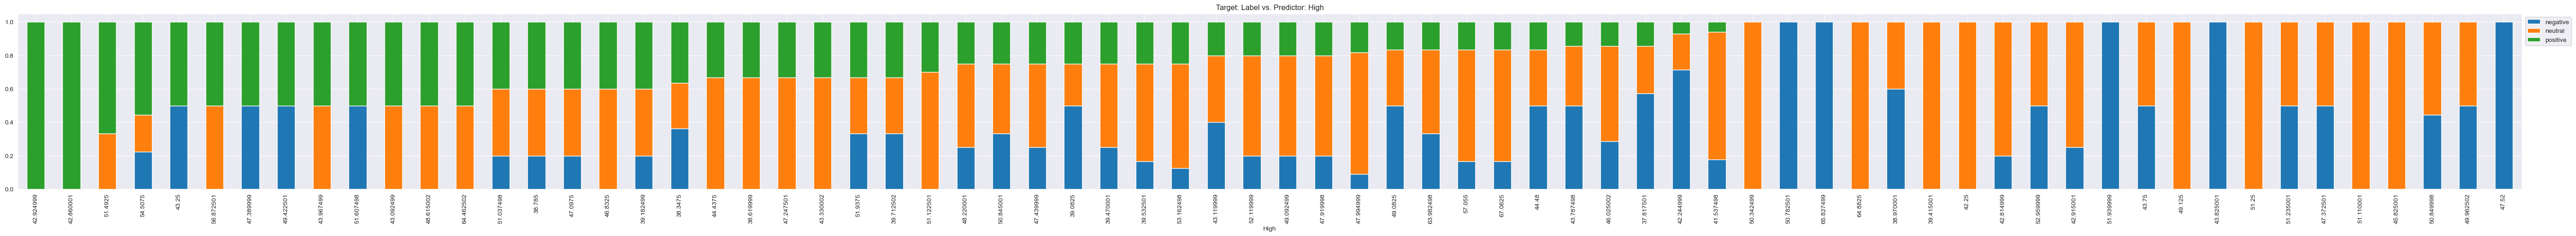

Label      negative  neutral  positive  All
Low                                        
All              99      170        80  349
51.685001         2        2         5    9
37.512501         4        3         4   11
38.154999         2        4         4   10
43.2225          14       10         4   28
...             ...      ...       ...  ...
47.134998         2        0         0    2
43.182499         1        1         0    2
43.2925           1        0         0    1
45.23             0        2         0    2
42.345001         1        4         0    5

[72 rows x 4 columns]
------------------------------------------------------------------------------------------------------------------------


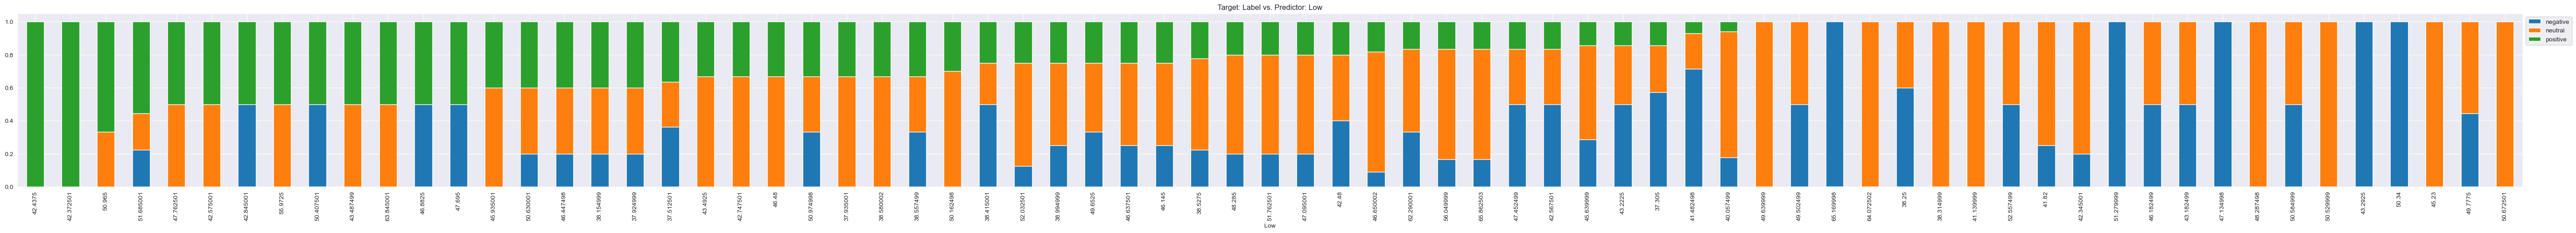

Label      negative  neutral  positive  All
Volume                                     
All              99      170        80  349
216071600         2        2         5    9
114843600         4        3         4   11
103544800        14       10         4   28
121576000         2        4         4   10
...             ...      ...       ...  ...
122278800         3        2         0    5
102785600         0        1         0    1
119284800         0        2         0    2
114430400         0        2         0    2
45448000          0        1         0    1

[72 rows x 4 columns]
------------------------------------------------------------------------------------------------------------------------


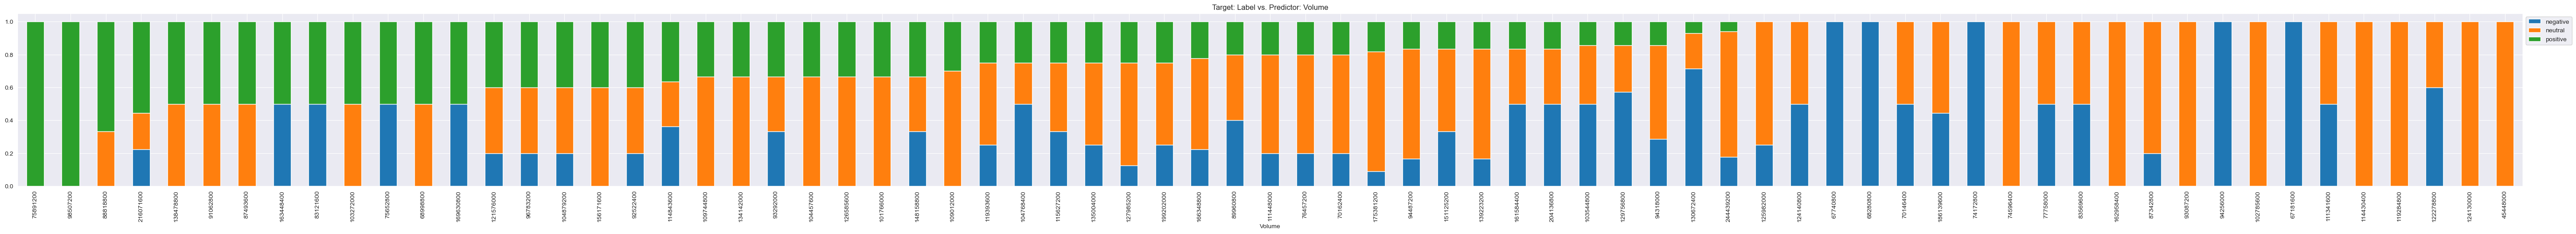

In [25]:
for i in non_category_columns:
    stacked_barplot(df, i, 'Label')

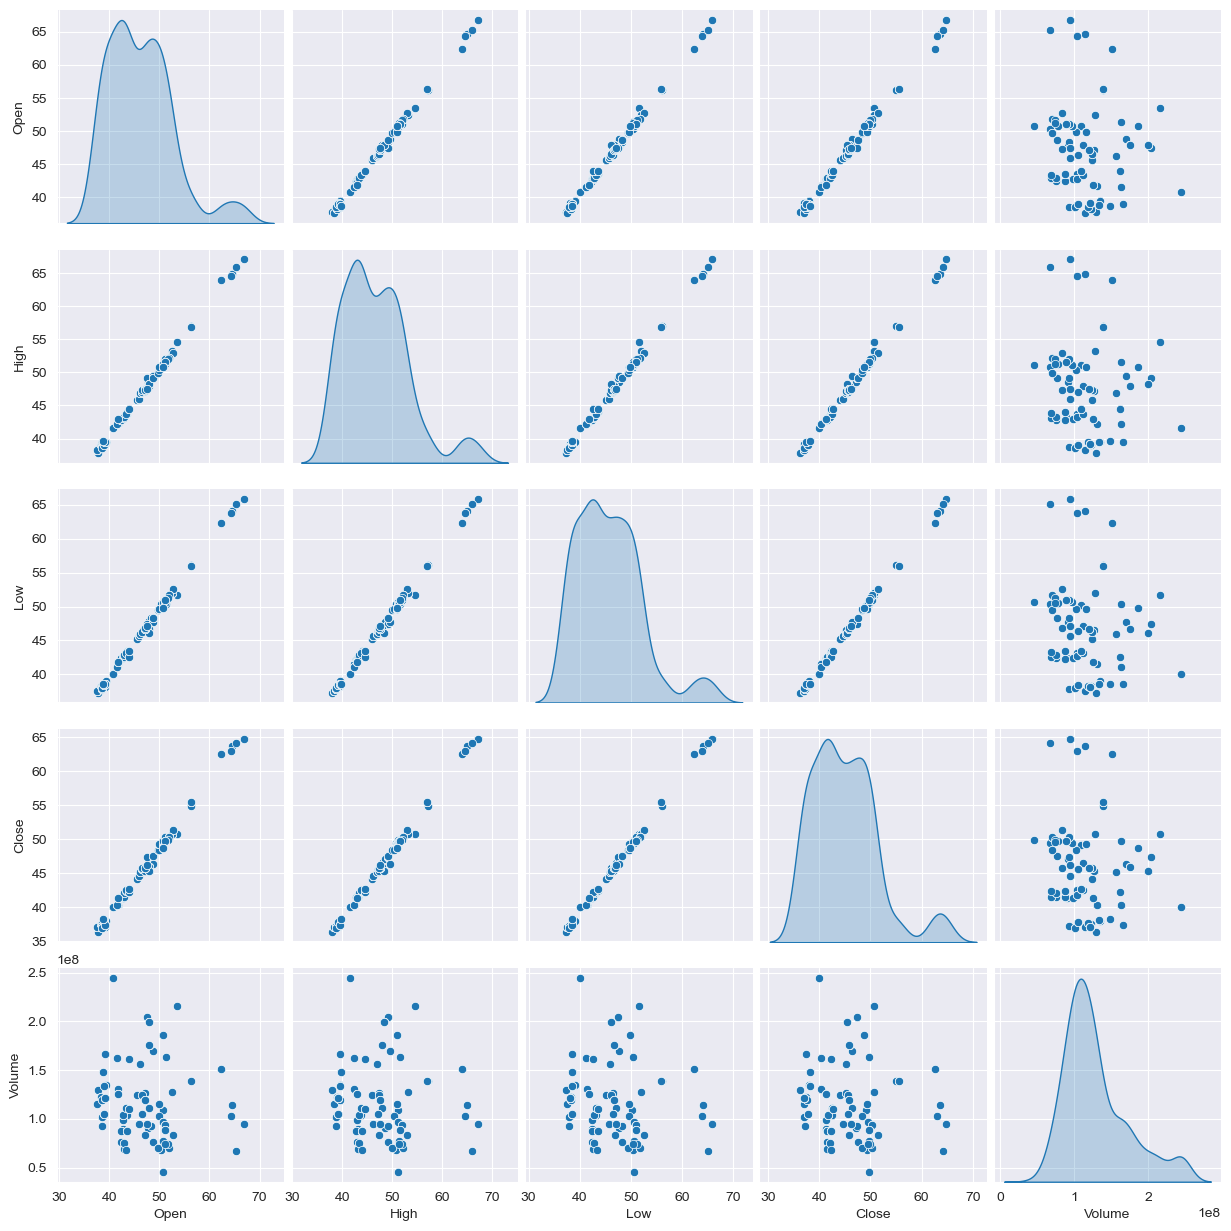

In [26]:
sns.pairplot(data=df, diag_kind="kde")
plt.show()

### Print the volume of transaction per day
As the Low/High, Open/Close is highly correlated, we don't need to print them.

In [27]:
df['Avg_Price'] = (df['Open'] + df['Close'] + df['High'] + df['Low']) / 4

In [28]:
df.head()

,Date,News,Open,High,Low,Close,Volume,Label,Avg_Price
0,2019-01-02,The tech sector experienced a significant dec...,41.740002,42.244999,41.482498,40.246914,130672400,negative,41.428603
12,2019-01-02,The dollar fell from above 109 to 106.67 afte...,41.740002,42.244999,41.482498,40.246914,130672400,negative,41.428603
11,2019-01-02,"In early Asian trading on Thursday, the Japan...",41.740002,42.244999,41.482498,40.246914,130672400,negative,41.428603
10,2019-01-02,The Australian dollar experienced significant...,41.740002,42.244999,41.482498,40.246914,130672400,neutral,41.428603
9,2019-01-02,Apple Inc. lowered its quarterly sales foreca...,41.740002,42.244999,41.482498,40.246914,130672400,negative,41.428603


In [29]:
stock_daily = df.groupby('Date').agg(
    Avg_Volume=('Volume', 'mean'),  # Compute the average of 'Volume'
    Mean_Price_Sum=('Avg_Price', 'mean')
)

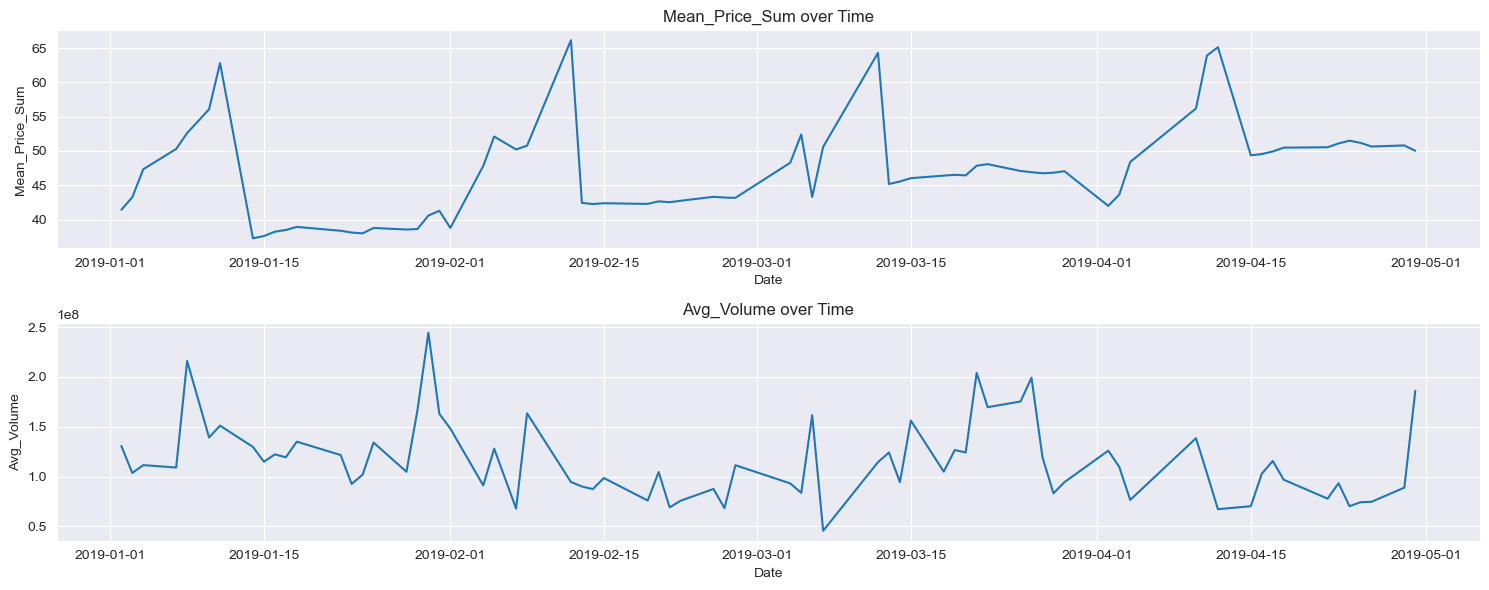

In [30]:
price = ['Mean_Price_Sum', 'Avg_Volume']
fig, axs = plt.subplots(len(price), 1, figsize=(15, 6))

for i, ax in enumerate(axs):
    sns.lineplot(y=stock_daily[price[i]], x=stock_daily.index, ax=ax)
    ax.set_title(f'{price[i]} over Time')

plt.tight_layout()
plt.show()

In [31]:
rev_label = {
    'positive': 2,
    'neutral': 1,
    'negative': 0
}
df['Label'] = df['Label'].map(rev_label)

In [32]:
lable_name = ['negative', 'neutral', 'positive']

## Data Preprocessing

Since the data is based on time (with the Date column), I should consider splitting your data chronologically. This will help simulate a real-world scenario where future prices are predicted based on past data.

### Text Preprocessing
To do the work embeddings we prepare the text with a pipeline that does:
* remove special characters
* lowercase the text
* remove extra whitespace
* remove stopwords
* perform stemming

In [33]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from nltk.stem.porter import PorterStemmer
import re
# to remove common stop words
from nltk.corpus import stopwords

# Create a custom transformer for text preprocessing
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stopwords = set(stopwords.words('english'))
        self.stemmer = PorterStemmer()

    def remove_special_characters(self, text):
        pattern = '[^A-Za-z0-9]+'
        return re.sub(pattern, ' ', text)

    def to_lowercase(self, text):
        return text.lower()

    def remove_extra_whitespaces(self, text):
        return text.strip()

    def remove_stopwords(self, text):
        return ' '.join([word for word in text.split() if word not in self.stopwords])

    def apply_stemming(self, text):
        return ' '.join([self.stemmer.stem(word) for word in text.split()])

    def preprocess(self, text):
        text = self.remove_special_characters(text)
        text = self.to_lowercase(text)
        text = self.remove_extra_whitespaces(text)
        text = self.remove_stopwords(text)
        return self.apply_stemming(text)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.apply(self.preprocess)

# Create a pipeline with the custom transformer
pipeline = Pipeline(steps=[
    ('text_preprocessing', FunctionTransformer(lambda x: TextPreprocessor().fit_transform(x), validate=False))
])

In [34]:
df['News_clean'] = pipeline.transform(df['News'])

In [35]:
df.head()

,Date,News,Open,High,Low,Close,Volume,Label,Avg_Price,News_clean
0,2019-01-02,The tech sector experienced a significant dec...,41.740002,42.244999,41.482498,40.246914,130672400,0,41.428603,tech sector experienc signific declin aftermar...
12,2019-01-02,The dollar fell from above 109 to 106.67 afte...,41.740002,42.244999,41.482498,40.246914,130672400,0,41.428603,dollar fell 109 106 67 appl revenu warn 10 yea...
11,2019-01-02,"In early Asian trading on Thursday, the Japan...",41.740002,42.244999,41.482498,40.246914,130672400,0,41.428603,earli asian trade thursday japanes yen surg u ...
10,2019-01-02,The Australian dollar experienced significant...,41.740002,42.244999,41.482498,40.246914,130672400,1,41.428603,australian dollar experienc signific volatil t...
9,2019-01-02,Apple Inc. lowered its quarterly sales foreca...,41.740002,42.244999,41.482498,40.246914,130672400,0,41.428603,appl inc lower quarterli sale forecast fiscal ...


In [36]:
print(f"Date set starting date: {df['Date'].min()}")
start_date = df['Date'].min()
print(f"Datea set end date: {df['Date'].max()}")
print(f"Duration: {df['Date'].max() - df['Date'].min()}")

Date set starting date: 2019-01-02 00:00:00
Datea set end date: 2019-04-30 00:00:00
Duration: 118 days 00:00:00


In [37]:
train_point = (df['Date'].max() - df['Date'].min())*0.7 # 60% of data
print(f"Train point: {train_point}")
test_val_split = (df['Date'].max() - df['Date'].min())*0.15 # 50% of the remaining %30
print(f"Test-Val Split: {test_val_split}")

Train point: 82 days 14:24:00
Test-Val Split: 17 days 16:48:00


In [38]:
X_train = df[(df['Date'] < start_date + train_point)].reset_index()    #Complete the code to select all rows where the 'Date' is before '2019-04-01'
X_val = df[(df['Date'] >= start_date + train_point) & (df['Date'] < start_date + train_point + test_val_split)].reset_index()    #Complete the code to select all rows where the 'Date' is from '2019-04-01 to '2019-04-16' (excluded)
X_test = df[df['Date'] >= start_date + train_point + test_val_split].reset_index()    #Complete the code to select all rows where the 'Date' is from '2019-04-16' till the end.

In [39]:
X_train.shape, X_val.shape, X_test.shape

((274, 11), (31, 11), (44, 11))

In [40]:
y_train = X_train['Label']
y_val = X_val['Label']
y_test = X_test['Label']

In [41]:
y_train.head()

0    0
1    0
2    0
3    1
4    0
Name: Label, dtype: int64

In [42]:
X_train.head()

,index,Date,News,Open,High,Low,Close,Volume,Label,Avg_Price,News_clean
0,0,2019-01-02,The tech sector experienced a significant dec...,41.740002,42.244999,41.482498,40.246914,130672400,0,41.428603,tech sector experienc signific declin aftermar...
1,12,2019-01-02,The dollar fell from above 109 to 106.67 afte...,41.740002,42.244999,41.482498,40.246914,130672400,0,41.428603,dollar fell 109 106 67 appl revenu warn 10 yea...
2,11,2019-01-02,"In early Asian trading on Thursday, the Japan...",41.740002,42.244999,41.482498,40.246914,130672400,0,41.428603,earli asian trade thursday japanes yen surg u ...
3,10,2019-01-02,The Australian dollar experienced significant...,41.740002,42.244999,41.482498,40.246914,130672400,1,41.428603,australian dollar experienc signific volatil t...
4,9,2019-01-02,Apple Inc. lowered its quarterly sales foreca...,41.740002,42.244999,41.482498,40.246914,130672400,0,41.428603,appl inc lower quarterli sale forecast fiscal ...


## Word Embeddings

### Word2Vec

In [43]:
# Creating a list of all words in our data
words_list = [item.split(" ") for item in df['News_clean'].values]

In [44]:
# Creating an instance of Word2Vec
vec_size = 300
model_W2V = Word2Vec(words_list, vector_size = vec_size, min_count = 1, window=5, workers = 6)

In [45]:
# Checking the size of the vocabulary
print("Length of the vocabulary for training is", len(list(model_W2V.wv.key_to_index)))

Length of the vocabulary for training is 2580


In [46]:
# Checking the word embedding of a random word
word = "stock"

In [47]:
model_W2V.wv[word]

array([ 3.59019055e-03,  9.03059822e-03,  4.81408613e-04,  6.33180188e-03,
       -8.80172302e-04, -1.21043371e-02,  7.46404612e-03,  1.77955423e-02,
        3.11241485e-03, -2.12547905e-03, -2.89112300e-04, -9.03007109e-03,
        1.05109197e-04,  3.83181893e-03, -9.25953686e-03, -6.45654043e-03,
        5.88768488e-03,  7.04223639e-04,  3.09262471e-03, -5.73404506e-03,
       -6.21343963e-03,  1.56089955e-04,  8.98908544e-03,  2.71088141e-03,
        9.98320803e-03,  9.02103493e-04, -1.07741198e-02, -1.61348039e-03,
       -3.83530348e-03, -1.19444160e-02,  5.14911814e-03, -1.54109974e-03,
       -2.41282047e-04,  1.96540053e-03, -5.53818652e-03,  4.73445468e-03,
        1.92716776e-03, -1.32224513e-02, -1.78800733e-03, -3.54749965e-03,
       -1.02663739e-03, -2.53413658e-04,  4.78012022e-03, -7.82751571e-03,
        6.31987909e-03,  1.32850036e-02,  5.25367679e-04,  1.99724594e-03,
       -4.39519668e-03,  7.89571740e-03,  2.52005807e-03, -8.67283728e-04,
       -9.65371821e-03,  

In [48]:
# Retrieving the words present in the Word2Vec model's vocabulary
words = list(model_W2V.wv.key_to_index.keys())

# Retrieving word vectors for all the words present in the model's vocabulary
wvs = model_W2V.wv[words].tolist()

# Creating a dictionary of words and their corresponding vectors
word_vector_dict = dict(zip(words, wvs))


In [49]:
# compute the average
def average_vectorizer_Word2Vec(doc, words, word_vector):
    """
    Computes the average vector representation of a sentence using Word2Vec.
    :param doc:
    :param words: list of words in the model vocabulary
    :param word_vector: dictionary of words and their corresponding vectors
    :return: feature vector
    """
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(word_vector[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [50]:
def vectorized_document(df, target, words, word_vector):
    """
    Vectorized a document using Word2Vec.
    :param df: the datafram to vectorize
    :param target: the target column to vectorize
    :param words: words in the model vocabulary
    :param word_vector: vocabulary of words and their corresponding vectors
    :return: a pd.Datafram
    """
    tmp = pd.DataFrame(df[target].apply(lambda x: average_vectorizer_Word2Vec(x, words, word_vector).tolist()))
    return pd.DataFrame(tmp[target].tolist(),columns=['Feature' + str(i) for i in range(vec_size)])


In [51]:
X_train_wv = vectorized_document(X_train, 'News_clean', words, word_vector_dict)
X_train_wv[['Open', 'Volume']] = X_train[['Open', 'Avg_Price']].astype(float)

In [52]:
X_val_wv = vectorized_document(X_val, 'News_clean', words, word_vector_dict)
X_val_wv[['Open', 'Volume']] = X_val[['Open', 'Avg_Price']].astype(float)

In [53]:
X_test_wv = vectorized_document(X_test, 'News_clean', words, word_vector_dict)
X_test_wv[['Open', 'Volume']] = X_val[['Open', 'Avg_Price']].astype(float)

### GloVe

In [54]:
# Converting the Stanford GloVe model vector format to word2vec
from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file = 'glove.6B.100d.txt'
word2vec_output_file = 'glove.6B.100d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

(400000, 100)

In [55]:
from gensim.models import KeyedVectors
# load the Stanford GloVe model
filename = 'glove.6B.100d.txt.word2vec'
glove_model = KeyedVectors.load_word2vec_format(filename, binary=False)

In [56]:
# Checking the size of the vocabulary
print("Length of the vocabulary is", len(glove_model.index_to_key))

Length of the vocabulary is 400000


In [57]:
word = "stock"
glove_model[word]

array([ 8.6341e-01,  6.9648e-01,  4.5794e-02, -9.5708e-03, -2.5498e-01,
       -7.4666e-01, -2.2086e-01, -4.4615e-01, -1.0423e-01, -9.9931e-01,
        7.2550e-02,  4.5049e-01, -5.9912e-02, -5.7837e-01, -4.6540e-01,
        4.3429e-02, -5.0570e-01, -1.5442e-01,  9.8250e-01, -8.1571e-02,
        2.6523e-01, -2.3734e-01,  9.7675e-02,  5.8588e-01, -1.2948e-01,
       -6.8956e-01, -1.2811e-01, -5.2265e-02, -6.7719e-01,  3.0190e-02,
        1.8058e-01,  8.6121e-01, -8.3206e-01, -5.6887e-02, -2.9578e-01,
        4.7180e-01,  1.2811e+00, -2.5228e-01,  4.9557e-02, -7.2455e-01,
        6.6758e-01, -1.1091e+00, -2.0493e-01, -5.8669e-01, -2.5375e-03,
        8.2777e-01, -4.9102e-01, -2.6475e-01,  4.3015e-01, -2.0516e+00,
       -3.3208e-01,  5.1845e-02,  5.2646e-01,  8.7452e-01, -9.0237e-01,
       -1.7366e+00, -3.4727e-01,  1.6590e-01,  2.7727e+00,  6.5756e-02,
       -4.0363e-01,  3.8252e-01, -3.0787e-01,  5.9202e-01,  1.3468e-01,
       -3.3851e-01,  3.3646e-01,  2.0950e-01,  8.5905e-01,  5.18

In [58]:
glove_words = glove_model.index_to_key

In [59]:
glove_word_vector_dict = dict(zip(glove_model.index_to_key,list(glove_model.vectors)))

In [60]:
# compute average
def average_vectorizer_GloVe(doc):
    """
    Computes the average vector representation of a sentence using GloVe.
    :param doc:
    :return: vector
    """
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in glove_words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(glove_word_vector_dict[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [61]:
vec_size=100

In [62]:
X_train_gl = vectorized_document(X_train, 'News_clean', glove_words, glove_word_vector_dict)
X_train_wv[['Open', 'Volume']] = X_train[['Open', 'Avg_Price']].astype(float)

In [63]:
X_val_gl = vectorized_document(X_val, 'News_clean', glove_words, glove_word_vector_dict)
X_val_wv[['Open', 'Volume']] = X_train[['Open', 'Avg_Price']].astype(float)

In [64]:
X_test_gl = vectorized_document(X_test, 'News_clean', glove_words, glove_word_vector_dict)
X_test_wv[['Open', 'Volume']] = X_train[['Open', 'Avg_Price']].astype(float)

### Sentence transformer

#### Defining the model

In [65]:
# to import the model
from sentence_transformers import SentenceTransformer

In [346]:
#Defining the model
model_st = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

#### Encoding the dataset

In [67]:
# importing the PyTorch Deep Learning library
import torch

In [68]:
# setting the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [284]:
# encoding the dataset
X_train_st = model_st.encode(X_train['News'], show_progress_bar=True, device=device)
X_val_st = model_st.encode(X_val['News'], show_progress_bar=True, device=device)
X_test_st = model_st.encode(X_test['News'], show_progress_bar=True, device=device)

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

In [285]:
# printing the shape of the embedding matrix
size = X_train_st.shape[1]

In [286]:
X_train_st = pd.DataFrame(X_train_st)
X_train_st.columns = ['Feature' + str(i) for i in range(size)]
X_train_st[['Avg_Price', 'Volume']] = X_train[['Avg_Price', 'Volume']].astype(float)

X_val_st = pd.DataFrame(X_val_st)
X_val_st.columns = ['Feature' + str(i) for i in range(size)]
X_val_st[['Avg_Price', 'Volume']] = X_val[['Avg_Price', 'Volume']].astype(float)

X_test_st = pd.DataFrame(X_test_st)
X_test_st.columns = ['Feature' + str(i) for i in range(size)]
X_test_st[['Avg_Price', 'Volume']] = X_test[['Avg_Price', 'Volume']].astype(float)


In [287]:
X_train_st.head()

,Feature0,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,...,Feature376,Feature377,Feature378,Feature379,Feature380,Feature381,Feature382,Feature383,Avg_Price,Volume
0,-0.002023,-0.036773,0.077354,0.046713,0.032552,0.002102,0.043283,0.039535,0.058228,0.008875,...,0.003257,-0.000594,-0.055096,-0.027134,-0.003575,-0.131502,0.074163,0.057510,41.428603,130672400.0
1,-0.012780,0.031235,0.069249,0.050970,0.003521,0.011309,-0.016394,0.093713,0.029073,0.011865,...,-0.045194,-0.048589,-0.079509,0.009867,-0.013045,-0.130929,0.002451,0.071128,41.428603,130672400.0
2,-0.042037,0.009255,0.033603,0.064445,-0.011054,-0.044355,-0.005383,0.102486,-0.023502,-0.019805,...,-0.061288,-0.017032,-0.051580,0.012518,0.014277,-0.080844,-0.091804,0.091269,41.428603,130672400.0
3,0.055039,0.044768,0.039391,0.048491,-0.026018,0.025621,-0.093378,0.042007,-0.017763,0.016295,...,-0.060392,-0.044364,-0.014683,-0.057679,0.045615,-0.099406,-0.048082,0.012353,41.428603,130672400.0
4,0.003485,0.053748,0.130674,0.060749,-0.005538,-0.025676,-0.003505,-0.012721,0.056925,0.002138,...,-0.029707,-0.066190,-0.077293,-0.016155,-0.000739,-0.075989,0.041348,0.062631,41.428603,130672400.0


In [288]:
X_val_st.head()

,Feature0,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,...,Feature376,Feature377,Feature378,Feature379,Feature380,Feature381,Feature382,Feature383,Avg_Price,Volume
0,0.000158,-0.029377,0.027311,0.009435,0.005225,0.013579,-0.035999,0.061863,0.049670,0.009670,...,-0.086341,0.028364,-0.049615,-0.039821,0.046718,-0.117746,0.015545,0.069136,46.904922,199202000.0
1,-0.045317,-0.045913,0.111688,0.099022,0.053137,0.001026,0.019429,0.022210,-0.019778,-0.026104,...,-0.045251,0.041996,-0.044994,-0.061237,0.072046,-0.127659,-0.022423,0.131794,46.904922,199202000.0
2,-0.022720,-0.031737,0.002823,0.034345,-0.044363,0.025113,-0.005354,0.007245,0.047596,-0.107752,...,-0.044412,-0.037354,0.031592,-0.081242,0.105062,-0.080331,0.048208,-0.031002,46.904922,199202000.0
3,-0.119170,0.008579,-0.011554,-0.010010,-0.008426,0.058581,0.052131,-0.017450,-0.006025,0.063895,...,0.049777,-0.077668,-0.022233,-0.021424,0.015831,-0.123832,0.051015,0.126861,46.904922,199202000.0
4,0.062285,0.001468,0.088982,0.094041,0.041820,0.020028,-0.075984,0.028246,-0.034589,-0.026689,...,-0.047273,0.056592,-0.066591,-0.093533,-0.043798,-0.096879,-0.111505,0.041723,46.753120,119393600.0


In [348]:
from transformers import pipeline
sentiment_hf = pipeline("sentiment-analysis")

# you can choose to use any other model by including a model argument like:
# sentiment_hf = pipeline(model="finiteautomata/bertweet-base-sentiment-analysis")
# or
# nlptown/bert-base-multilingual-uncased-sentiment
# many more models can be found at https://huggingface.co/models?pipeline_tag=text-classification&sort=trending&search=sentiment
# these are all text-classification models...sentiment analysis is a special case of text classification

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [356]:
df['News'].loc[2]

" Apple cut its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weaker demand in China and fewer iPhone upgrades. CEO Tim Cook also mentioned constrained sales of Airpods and Macbooks. Apple's shares fell 8.5% in post market trading, while Asian suppliers like Hon"

In [357]:
df['Label'].loc[2]

0

In [358]:
trial_data = [df['News'].loc[2]]
sentiment_hf(trial_data)

[{'label': 'NEGATIVE', 'score': 0.999474823474884}]

## Sentiment Analysis

### Model evaluation criterion
The data set is farily imbalance between the neutral and the positive and negative sentiment. The neutral represents 49% while the negative represents 28% and the positive represents 23% of the dataset. We would like to focus on the true positive rate. As the majority of the sentiment is neutral, we will focus on the F1-Score. The F1-Score will give us a better metric to avoid the model form being too biased toward a dominant class, as the model might focuses more on the neutral sentiment, the F1-Score will help to balance this by accounting for both false positives and false negatives.

In [250]:
def plot_confusion_matrix(model, predictors, target, pred=None, labels_name=None):
    """
    Plot a confusion matrix to visualize the performance of a classification model.

    Parameters:
        model : The  model to evaluate.
        predictors : The independent variables used for predictions.
        target : The dependent variable used for predictions.
        pred : The predictions to be used. If None, then it will be computed by calling the model.predict method.
        labels_name : The names of the classes to be used. If None, then it will be used as the target variable.

    Returns:
    None: Displays the confusion matrix plot.
    """
    if pred is None:
        pred = model.predict(predictors)  # Make predictions using the classifier.
    
    cm = confusion_matrix(y_true=target, y_pred=pred)  # Compute the confusion matrix.

    plt.figure(figsize=(7, 6))  # Create a new figure with a specified size.

    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(cm.shape[0], cm.shape[1])
    sns.heatmap(cm, annot=labels, fmt="", xticklabels=labels_name, yticklabels=labels_name)
    # Plot the confusion matrix using a heatmap with annotations.

    plt.ylabel('Actual')  # Label for the y-axis.
    plt.xlabel('Predicted')  # Label for the x-axis.
    plt.title('Confusion Matrix')  # Title of the plot.
    plt.show()  # Display the plot.

In [73]:
def model_performance_classification_sklearn(model, predictors, target):
    """
    Compute various performance metrics for a classification model using sklearn.

    Parameters:
    model (sklearn classifier): The classification model to evaluate.
    predictors (array-like): The independent variables used for predictions.
    target (array-like): The true labels for the dependent variable.

    Returns:
    pandas.DataFrame: A DataFrame containing the computed metrics (Accuracy, Recall, Precision, F1-score).
    """
    pred = model.predict(predictors)  # Make predictions using the classifier.

    acc = accuracy_score(target, pred)  # Compute Accuracy.
    recall = recall_score(target, pred,average='weighted')  # Compute Recall.
    precision = precision_score(target, pred,average='weighted')  # Compute Precision.
    f1 = f1_score(target, pred,average='weighted')  # Compute F1-score.

    # Create a DataFrame to store the computed metrics.
    df_perf = pd.DataFrame(
        {
            "Accuracy": [acc],
            "Recall": [recall],
            "Precision": [precision],
            "F1": [f1],
        }
    )

    return df_perf  # Return the DataFrame with the metrics.

### Base Models

In [74]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1, class_weight='balanced')))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1, algorithm='SAMME')))
models.append(("dtree", DecisionTreeClassifier(random_state=1, class_weight='balanced')))
models.append(("XGB", XGBClassifier(random_state=1)))

In [75]:
def preprocess(X):
    """
    Convert Timestamps to numerical values (e.g., Unix timestamps).
    """
    for col in X.select_dtypes(include=['datetime64[ns]']):
        X[col] = X[col].astype('int64') // 1e9  # convert to Unix timestamp
    return X

In [296]:
from sklearn.metrics import classification_report

def Apply_model(X, y, X_val=None, y_val=None):
    """
    
    :param X: input features
    :param y: target
    :return: a datafram with each model's results/performance
    """
    result = []
    result_val = None
    validation = False
    
    if X_val is not None and y_val is not None:
        validation = True
        result_val = []
    
    for name, model in models:
        print('='*80)
        print(f"Model: {name}")
        print('='*80)
        # convert data into Unix Epoch, so no one is complaining and it gives an integer that represents temporality
        X = preprocess(X)
        model.fit(X, y)
        y_pred = model.predict(X)

        # if we have a validation set 
        if validation is True:
            y_pred_val = model.predict(X_val)
            
        print('-'*20, "Confusion Matrix", '-'*20)
        plot_confusion_matrix(model, X, y, y_pred, labels_name=lable_name)
        if validation is True:
            print('-'*20, "Confusion Matrix ---- Validation set", '-'*20)
            plot_confusion_matrix(model, X_val, y_val, y_pred_val, labels_name=lable_name)
        
        print('-'*20, "classification report", '-'*20)
        res_dict = classification_report(y, y_pred, target_names=lable_name, output_dict=True)
        tmp_df = pd.DataFrame(res_dict)
        print(tmp_df.head())
        result.append([name, tmp_df])
        
        if validation is True:
            print('-'*20, "classification report ---- Validation set", '-'*20)
            res_dict_val = classification_report(y_val, y_pred_val, target_names=lable_name, output_dict=True)
            tmp_df_val = pd.DataFrame(res_dict_val)
            print(tmp_df_val.head())
            result_val.append([name, tmp_df_val])
        
            
        
    return result, result_val
        

#### Base Model - Word2Vec
As the dataset is not large and it is imbalanced, we select the GradientBoostingClassifier to start.

Model: Bagging
-------------------- Confusion Matrix --------------------


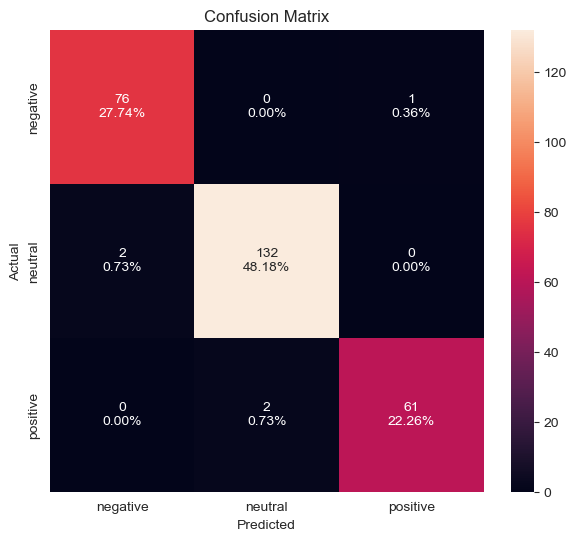

-------------------- Confusion Matrix ---- Validation set --------------------


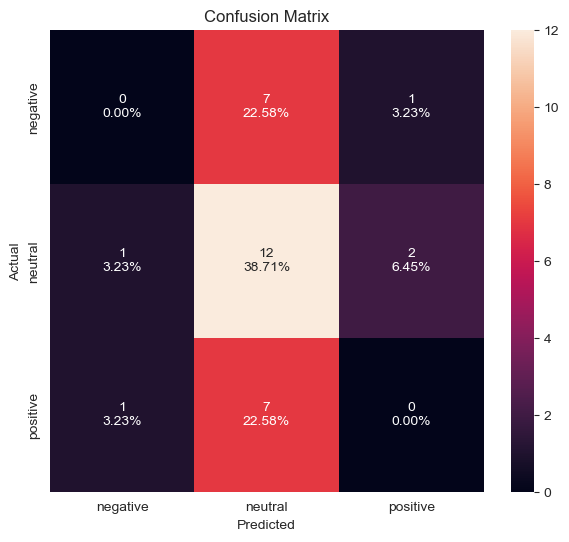

-------------------- classification report --------------------
            negative     neutral   positive  accuracy   macro avg  \
precision   0.974359    0.985075   0.983871  0.981752    0.981102   
recall      0.987013    0.985075   0.968254  0.981752    0.980114   
f1-score    0.980645    0.985075   0.976000  0.981752    0.980573   
support    77.000000  134.000000  63.000000  0.981752  274.000000   

           weighted avg  
precision      0.981787  
recall         0.981752  
f1-score       0.981743  
support      274.000000  
-------------------- classification report ---- Validation set --------------------
           negative    neutral  positive  accuracy  macro avg  weighted avg
precision       0.0   0.461538       0.0  0.387097   0.153846      0.223325
recall          0.0   0.800000       0.0  0.387097   0.266667      0.387097
f1-score        0.0   0.585366       0.0  0.387097   0.195122      0.283242
support         8.0  15.000000       8.0  0.387097  31.000000     31.000

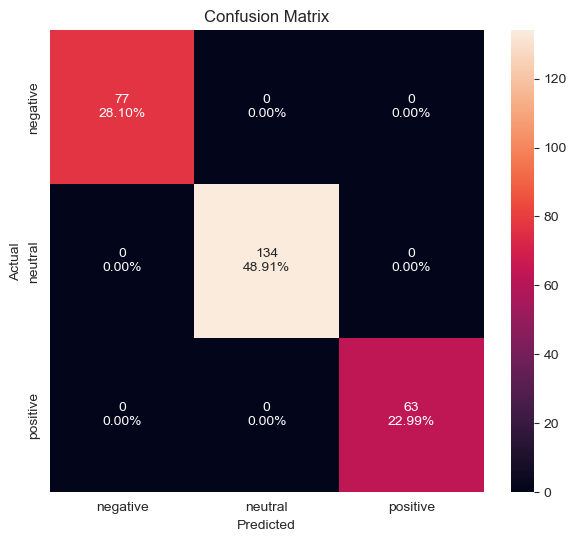

-------------------- Confusion Matrix ---- Validation set --------------------


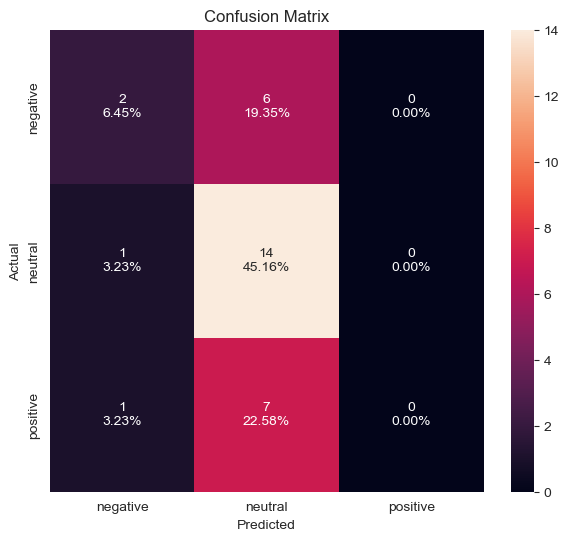

-------------------- classification report --------------------
           negative  neutral  positive  accuracy  macro avg  weighted avg
precision       1.0      1.0       1.0       1.0        1.0           1.0
recall          1.0      1.0       1.0       1.0        1.0           1.0
f1-score        1.0      1.0       1.0       1.0        1.0           1.0
support        77.0    134.0      63.0       1.0      274.0         274.0
-------------------- classification report ---- Validation set --------------------
           negative    neutral  positive  accuracy  macro avg  weighted avg
precision  0.500000   0.518519       0.0  0.516129   0.339506      0.379928
recall     0.250000   0.933333       0.0  0.516129   0.394444      0.516129
f1-score   0.333333   0.666667       0.0  0.516129   0.333333      0.408602
support    8.000000  15.000000       8.0  0.516129  31.000000     31.000000
Model: GBM
-------------------- Confusion Matrix --------------------


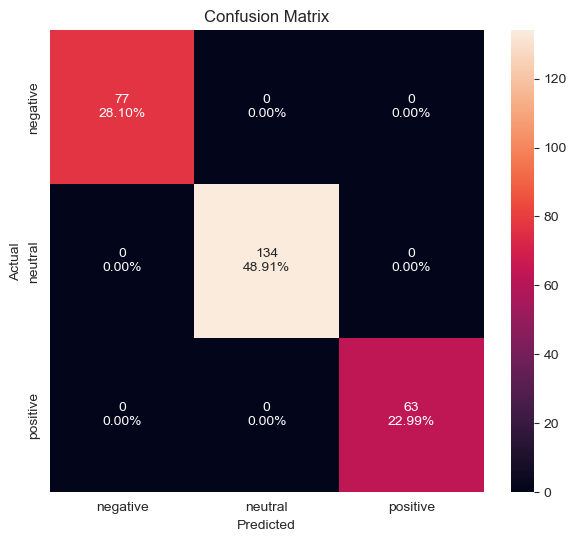

-------------------- Confusion Matrix ---- Validation set --------------------


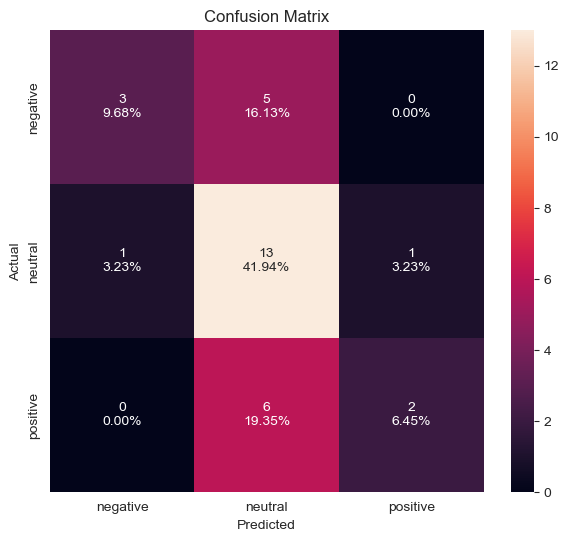

-------------------- classification report --------------------
           negative  neutral  positive  accuracy  macro avg  weighted avg
precision       1.0      1.0       1.0       1.0        1.0           1.0
recall          1.0      1.0       1.0       1.0        1.0           1.0
f1-score        1.0      1.0       1.0       1.0        1.0           1.0
support        77.0    134.0      63.0       1.0      274.0         274.0
-------------------- classification report ---- Validation set --------------------
           negative    neutral  positive  accuracy  macro avg  weighted avg
precision     0.750   0.541667  0.666667  0.580645   0.652778      0.627688
recall        0.375   0.866667  0.250000  0.580645   0.497222      0.580645
f1-score      0.500   0.666667  0.363636  0.580645   0.510101      0.545455
support       8.000  15.000000  8.000000  0.580645  31.000000     31.000000
Model: Adaboost
-------------------- Confusion Matrix --------------------


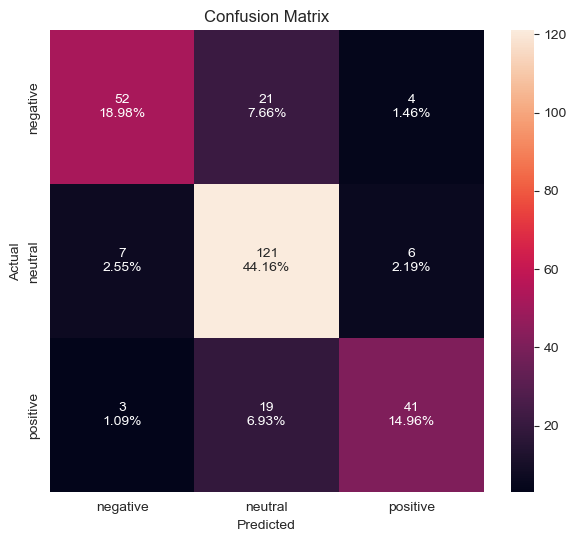

-------------------- Confusion Matrix ---- Validation set --------------------


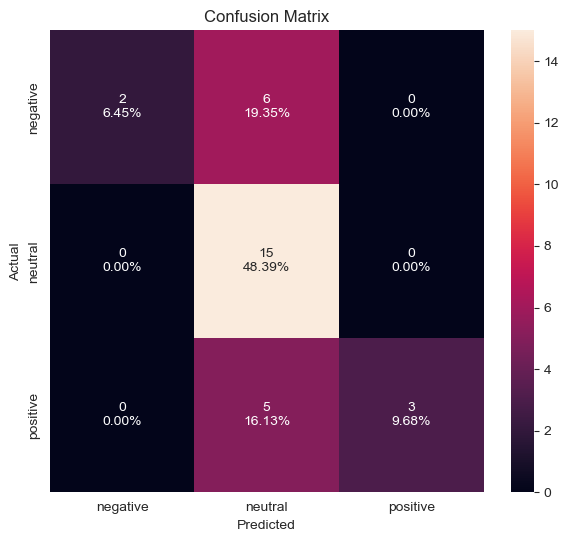

-------------------- classification report --------------------
            negative     neutral   positive  accuracy   macro avg  \
precision   0.838710    0.751553   0.803922  0.781022    0.798061   
recall      0.675325    0.902985   0.650794  0.781022    0.743034   
f1-score    0.748201    0.820339   0.719298  0.781022    0.762613   
support    77.000000  134.000000  63.000000  0.781022  274.000000   

           weighted avg  
precision      0.788087  
recall         0.781022  
f1-score       0.776835  
support      274.000000  
-------------------- classification report ---- Validation set --------------------
           negative    neutral  positive  accuracy  macro avg  weighted avg
precision      1.00   0.576923  1.000000  0.645161   0.858974      0.795285
recall         0.25   1.000000  0.375000  0.645161   0.541667      0.645161
f1-score       0.40   0.731707  0.545455  0.645161   0.559054      0.598040
support        8.00  15.000000  8.000000  0.645161  31.000000     31.000

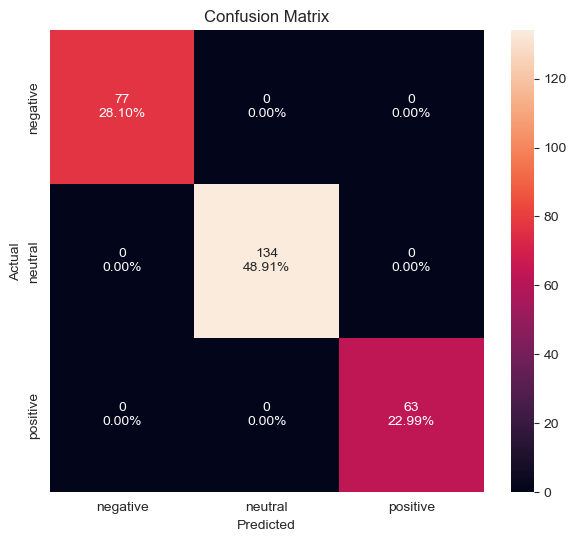

-------------------- Confusion Matrix ---- Validation set --------------------


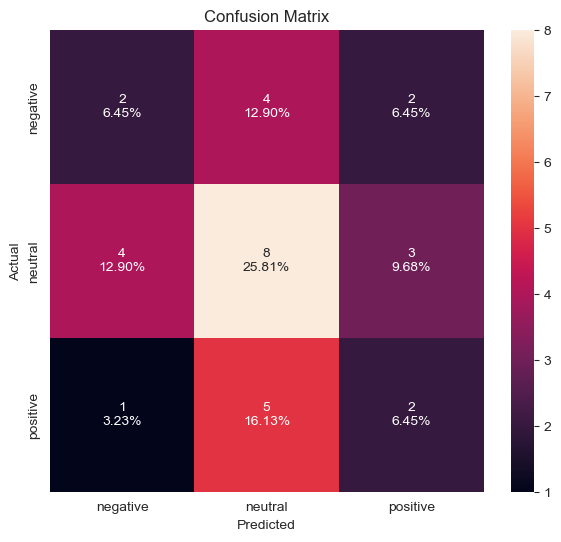

-------------------- classification report --------------------
           negative  neutral  positive  accuracy  macro avg  weighted avg
precision       1.0      1.0       1.0       1.0        1.0           1.0
recall          1.0      1.0       1.0       1.0        1.0           1.0
f1-score        1.0      1.0       1.0       1.0        1.0           1.0
support        77.0    134.0      63.0       1.0      274.0         274.0
-------------------- classification report ---- Validation set --------------------
           negative    neutral  positive  accuracy  macro avg  weighted avg
precision  0.285714   0.470588  0.285714  0.387097   0.347339      0.375169
recall     0.250000   0.533333  0.250000  0.387097   0.344444      0.387097
f1-score   0.266667   0.500000  0.266667  0.387097   0.344444      0.379570
support    8.000000  15.000000  8.000000  0.387097  31.000000     31.000000
Model: XGB
-------------------- Confusion Matrix --------------------


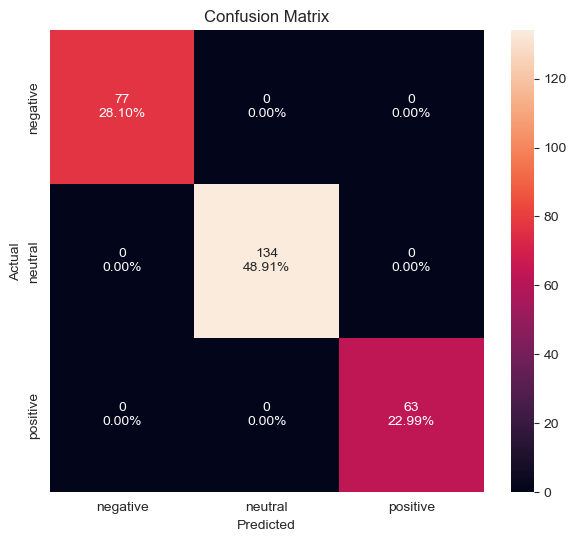

-------------------- Confusion Matrix ---- Validation set --------------------


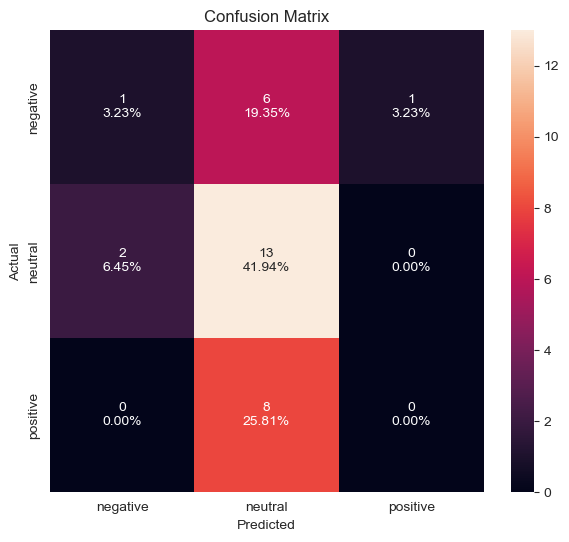

-------------------- classification report --------------------
           negative  neutral  positive  accuracy  macro avg  weighted avg
precision       1.0      1.0       1.0       1.0        1.0           1.0
recall          1.0      1.0       1.0       1.0        1.0           1.0
f1-score        1.0      1.0       1.0       1.0        1.0           1.0
support        77.0    134.0      63.0       1.0      274.0         274.0
-------------------- classification report ---- Validation set --------------------
           negative    neutral  positive  accuracy  macro avg  weighted avg
precision  0.333333   0.481481       0.0  0.451613   0.271605      0.318996
recall     0.125000   0.866667       0.0  0.451613   0.330556      0.451613
f1-score   0.181818   0.619048       0.0  0.451613   0.266955      0.346460
support    8.000000  15.000000       8.0  0.451613  31.000000     31.000000


In [297]:
result_base_wv_model_training, result_base_wv_model_val = Apply_model(X_train_wv, y_train, X_val_wv, y_val)

In [298]:
result_base_wv_model_training

[['Bagging',
              negative     neutral   positive  accuracy   macro avg  \
  precision   0.974359    0.985075   0.983871  0.981752    0.981102   
  recall      0.987013    0.985075   0.968254  0.981752    0.980114   
  f1-score    0.980645    0.985075   0.976000  0.981752    0.980573   
  support    77.000000  134.000000  63.000000  0.981752  274.000000   
  
             weighted avg  
  precision      0.981787  
  recall         0.981752  
  f1-score       0.981743  
  support      274.000000  ],
 ['Random forest',
             negative  neutral  positive  accuracy  macro avg  weighted avg
  precision       1.0      1.0       1.0       1.0        1.0           1.0
  recall          1.0      1.0       1.0       1.0        1.0           1.0
  f1-score        1.0      1.0       1.0       1.0        1.0           1.0
  support        77.0    134.0      63.0       1.0      274.0         274.0],
 ['GBM',
             negative  neutral  positive  accuracy  macro avg  weighted avg
 

In [299]:
result_base_wv_model_val

[['Bagging',
             negative    neutral  positive  accuracy  macro avg  weighted avg
  precision       0.0   0.461538       0.0  0.387097   0.153846      0.223325
  recall          0.0   0.800000       0.0  0.387097   0.266667      0.387097
  f1-score        0.0   0.585366       0.0  0.387097   0.195122      0.283242
  support         8.0  15.000000       8.0  0.387097  31.000000     31.000000],
 ['Random forest',
             negative    neutral  positive  accuracy  macro avg  weighted avg
  precision  0.500000   0.518519       0.0  0.516129   0.339506      0.379928
  recall     0.250000   0.933333       0.0  0.516129   0.394444      0.516129
  f1-score   0.333333   0.666667       0.0  0.516129   0.333333      0.408602
  support    8.000000  15.000000       8.0  0.516129  31.000000     31.000000],
 ['GBM',
             negative    neutral  positive  accuracy  macro avg  weighted avg
  precision     0.750   0.541667  0.666667  0.580645   0.652778      0.627688
  recall        0.3

#### Base Model - GloVe

Model: Bagging
-------------------- Confusion Matrix --------------------


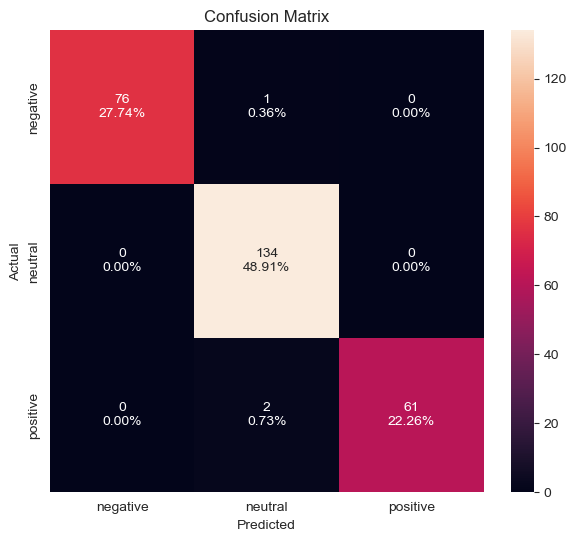

-------------------- Confusion Matrix ---- Validation set --------------------


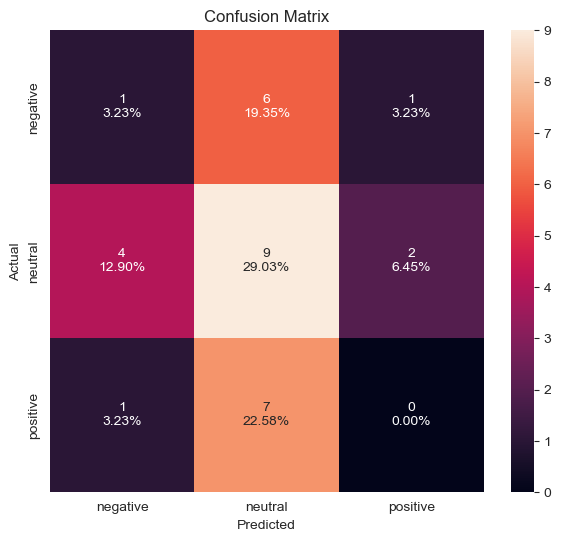

-------------------- classification report --------------------
            negative     neutral   positive  accuracy   macro avg  \
precision   1.000000    0.978102   1.000000  0.989051    0.992701   
recall      0.987013    1.000000   0.968254  0.989051    0.985089   
f1-score    0.993464    0.988930   0.983871  0.989051    0.988755   
support    77.000000  134.000000  63.000000  0.989051  274.000000   

           weighted avg  
precision      0.989291  
recall         0.989051  
f1-score       0.989041  
support      274.000000  
-------------------- classification report ---- Validation set --------------------
           negative    neutral  positive  accuracy  macro avg  weighted avg
precision  0.166667   0.409091       0.0  0.322581   0.191919      0.240958
recall     0.125000   0.600000       0.0  0.322581   0.241667      0.322581
f1-score   0.142857   0.486486       0.0  0.322581   0.209781      0.272263
support    8.000000  15.000000       8.0  0.322581  31.000000     31.000

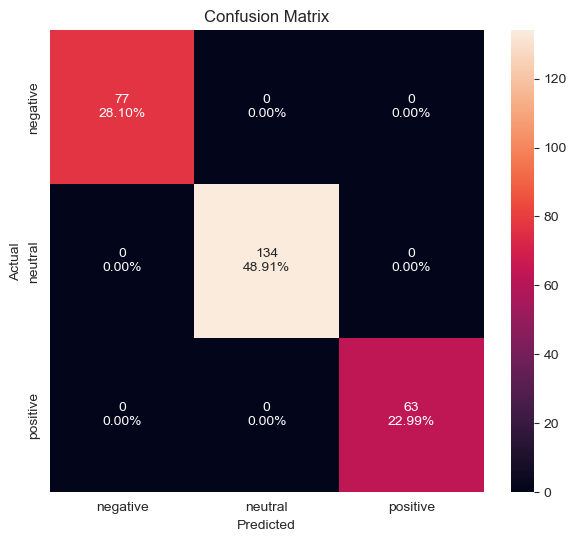

-------------------- Confusion Matrix ---- Validation set --------------------


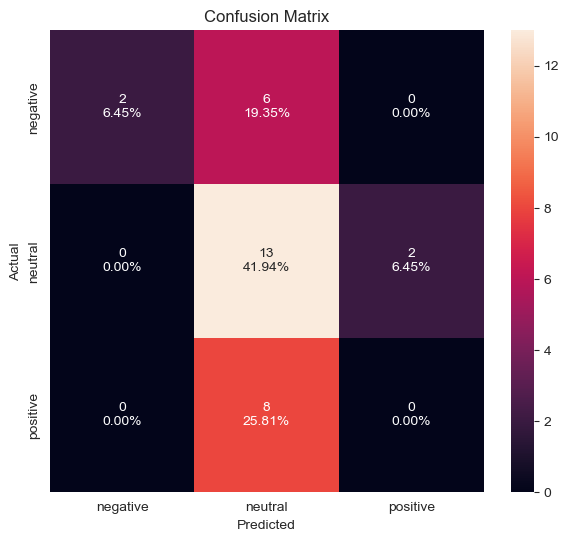

-------------------- classification report --------------------
           negative  neutral  positive  accuracy  macro avg  weighted avg
precision       1.0      1.0       1.0       1.0        1.0           1.0
recall          1.0      1.0       1.0       1.0        1.0           1.0
f1-score        1.0      1.0       1.0       1.0        1.0           1.0
support        77.0    134.0      63.0       1.0      274.0         274.0
-------------------- classification report ---- Validation set --------------------
           negative    neutral  positive  accuracy  macro avg  weighted avg
precision      1.00   0.481481       0.0  0.483871   0.493827      0.491039
recall         0.25   0.866667       0.0  0.483871   0.372222      0.483871
f1-score       0.40   0.619048       0.0  0.483871   0.339683      0.402765
support        8.00  15.000000       8.0  0.483871  31.000000     31.000000
Model: GBM
-------------------- Confusion Matrix --------------------


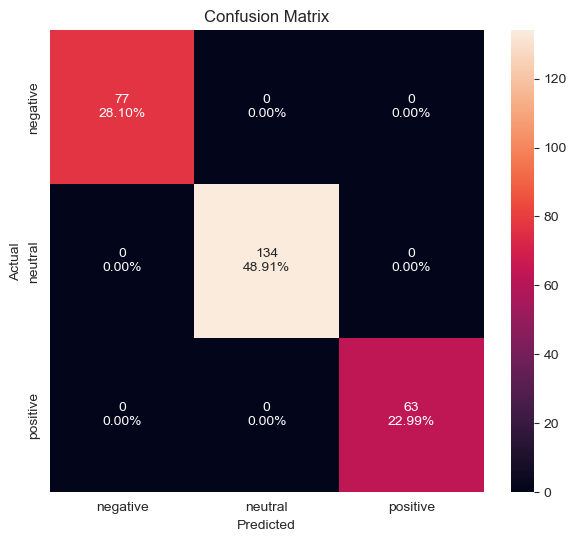

-------------------- Confusion Matrix ---- Validation set --------------------


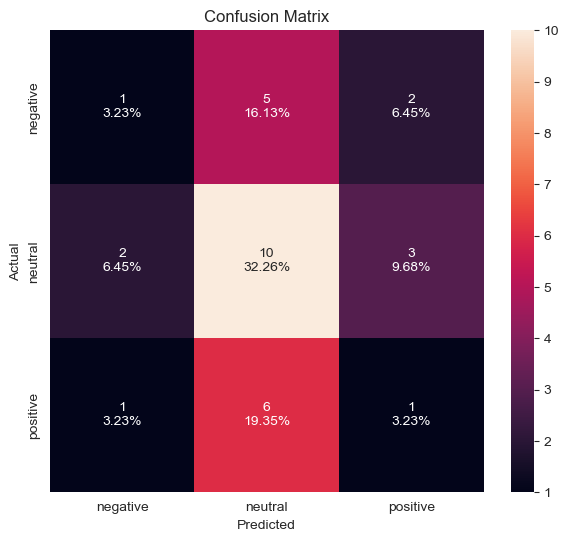

-------------------- classification report --------------------
           negative  neutral  positive  accuracy  macro avg  weighted avg
precision       1.0      1.0       1.0       1.0        1.0           1.0
recall          1.0      1.0       1.0       1.0        1.0           1.0
f1-score        1.0      1.0       1.0       1.0        1.0           1.0
support        77.0    134.0      63.0       1.0      274.0         274.0
-------------------- classification report ---- Validation set --------------------
           negative    neutral  positive  accuracy  macro avg  weighted avg
precision  0.250000   0.476190  0.166667  0.387097   0.297619      0.337942
recall     0.125000   0.666667  0.125000  0.387097   0.305556      0.387097
f1-score   0.166667   0.555556  0.142857  0.387097   0.288360      0.348694
support    8.000000  15.000000  8.000000  0.387097  31.000000     31.000000
Model: Adaboost
-------------------- Confusion Matrix --------------------


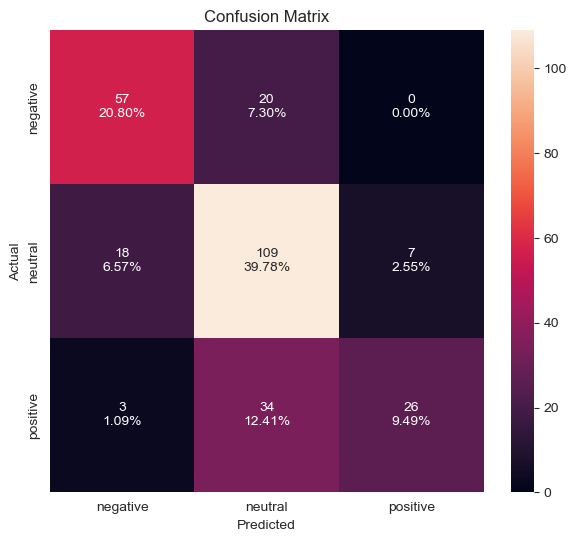

-------------------- Confusion Matrix ---- Validation set --------------------


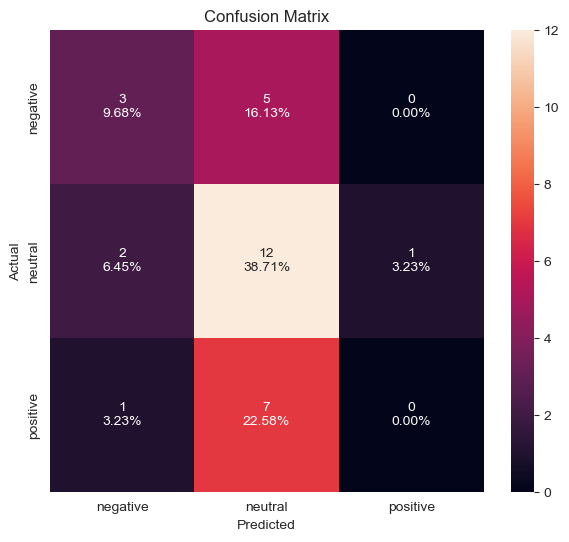

-------------------- classification report --------------------
            negative     neutral   positive  accuracy   macro avg  \
precision   0.730769    0.668712   0.787879   0.70073    0.729120   
recall      0.740260    0.813433   0.412698   0.70073    0.655464   
f1-score    0.735484    0.734007   0.541667   0.70073    0.670386   
support    77.000000  134.000000  63.000000   0.70073  274.000000   

           weighted avg  
precision      0.713551  
recall         0.700730  
f1-score       0.690198  
support      274.000000  
-------------------- classification report ---- Validation set --------------------
           negative    neutral  positive  accuracy  macro avg  weighted avg
precision  0.500000   0.500000       0.0  0.483871   0.333333      0.370968
recall     0.375000   0.800000       0.0  0.483871   0.391667      0.483871
f1-score   0.428571   0.615385       0.0  0.483871   0.347985      0.408366
support    8.000000  15.000000       8.0  0.483871  31.000000     31.000

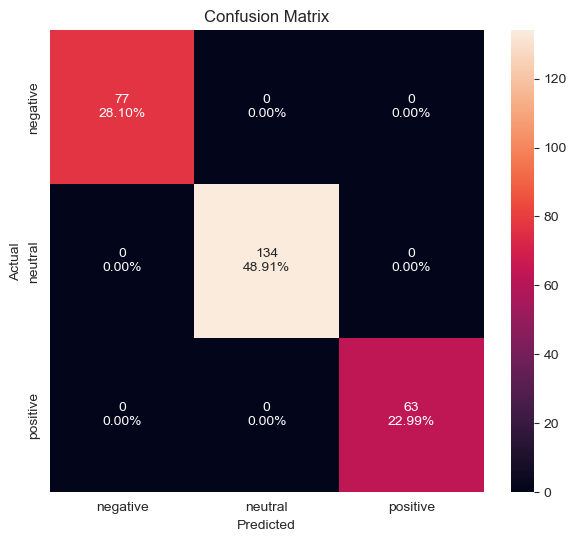

-------------------- Confusion Matrix ---- Validation set --------------------


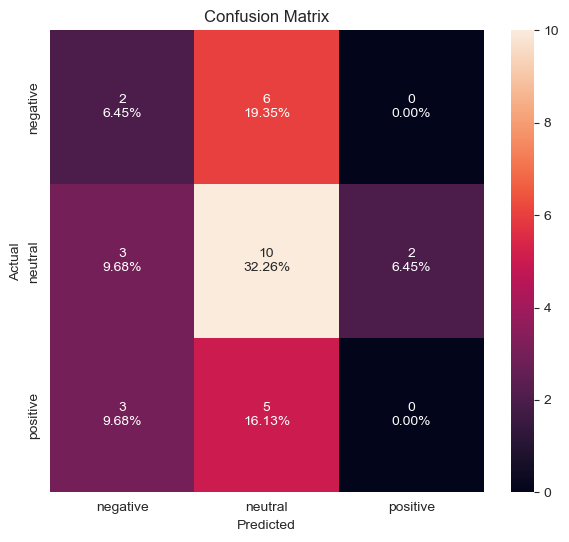

-------------------- classification report --------------------
           negative  neutral  positive  accuracy  macro avg  weighted avg
precision       1.0      1.0       1.0       1.0        1.0           1.0
recall          1.0      1.0       1.0       1.0        1.0           1.0
f1-score        1.0      1.0       1.0       1.0        1.0           1.0
support        77.0    134.0      63.0       1.0      274.0         274.0
-------------------- classification report ---- Validation set --------------------
           negative    neutral  positive  accuracy  macro avg  weighted avg
precision      0.25   0.476190       0.0  0.387097   0.242063      0.294931
recall         0.25   0.666667       0.0  0.387097   0.305556      0.387097
f1-score       0.25   0.555556       0.0  0.387097   0.268519      0.333333
support        8.00  15.000000       8.0  0.387097  31.000000     31.000000
Model: XGB
-------------------- Confusion Matrix --------------------


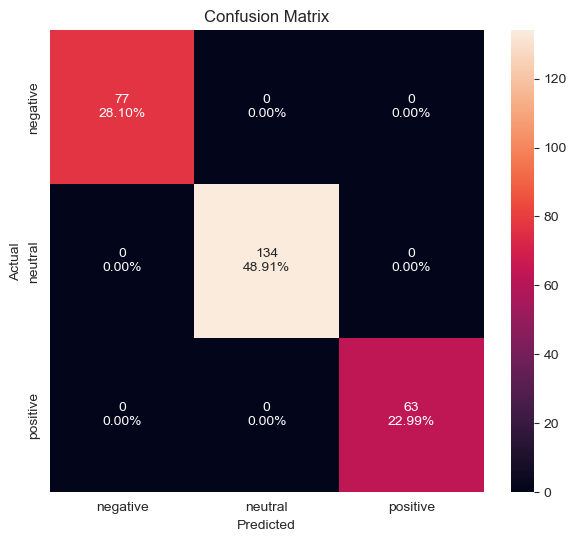

-------------------- Confusion Matrix ---- Validation set --------------------


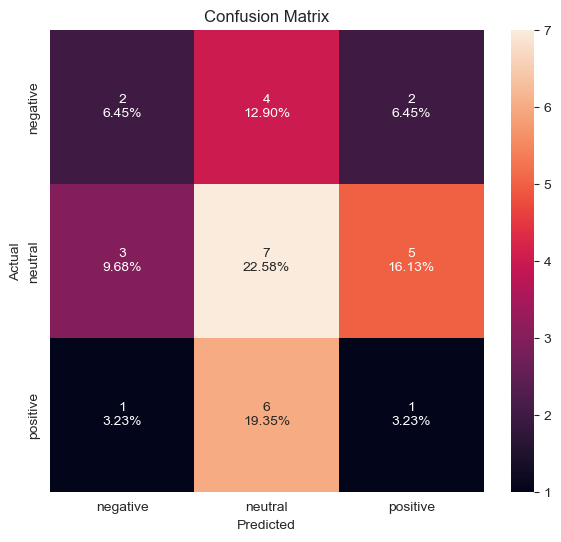

-------------------- classification report --------------------
           negative  neutral  positive  accuracy  macro avg  weighted avg
precision       1.0      1.0       1.0       1.0        1.0           1.0
recall          1.0      1.0       1.0       1.0        1.0           1.0
f1-score        1.0      1.0       1.0       1.0        1.0           1.0
support        77.0    134.0      63.0       1.0      274.0         274.0
-------------------- classification report ---- Validation set --------------------
           negative    neutral  positive  accuracy  macro avg  weighted avg
precision  0.333333   0.411765     0.125  0.322581   0.290033      0.317521
recall     0.250000   0.466667     0.125  0.322581   0.280556      0.322581
f1-score   0.285714   0.437500     0.125  0.322581   0.282738      0.317684
support    8.000000  15.000000     8.000  0.322581  31.000000     31.000000


In [300]:
result_base_gl_model_training,  result_base_gl_model_val= Apply_model(X_train_gl, y_train, X_val_gl, y_val)

In [302]:
result_base_gl_model_training

[['Bagging',
              negative     neutral   positive  accuracy   macro avg  \
  precision   1.000000    0.978102   1.000000  0.989051    0.992701   
  recall      0.987013    1.000000   0.968254  0.989051    0.985089   
  f1-score    0.993464    0.988930   0.983871  0.989051    0.988755   
  support    77.000000  134.000000  63.000000  0.989051  274.000000   
  
             weighted avg  
  precision      0.989291  
  recall         0.989051  
  f1-score       0.989041  
  support      274.000000  ],
 ['Random forest',
             negative  neutral  positive  accuracy  macro avg  weighted avg
  precision       1.0      1.0       1.0       1.0        1.0           1.0
  recall          1.0      1.0       1.0       1.0        1.0           1.0
  f1-score        1.0      1.0       1.0       1.0        1.0           1.0
  support        77.0    134.0      63.0       1.0      274.0         274.0],
 ['GBM',
             negative  neutral  positive  accuracy  macro avg  weighted avg
 

In [303]:
result_base_gl_model_val

[['Bagging',
             negative    neutral  positive  accuracy  macro avg  weighted avg
  precision  0.166667   0.409091       0.0  0.322581   0.191919      0.240958
  recall     0.125000   0.600000       0.0  0.322581   0.241667      0.322581
  f1-score   0.142857   0.486486       0.0  0.322581   0.209781      0.272263
  support    8.000000  15.000000       8.0  0.322581  31.000000     31.000000],
 ['Random forest',
             negative    neutral  positive  accuracy  macro avg  weighted avg
  precision      1.00   0.481481       0.0  0.483871   0.493827      0.491039
  recall         0.25   0.866667       0.0  0.483871   0.372222      0.483871
  f1-score       0.40   0.619048       0.0  0.483871   0.339683      0.402765
  support        8.00  15.000000       8.0  0.483871  31.000000     31.000000],
 ['GBM',
             negative    neutral  positive  accuracy  macro avg  weighted avg
  precision  0.250000   0.476190  0.166667  0.387097   0.297619      0.337942
  recall     0.1250

#### Base Model - Sentence Transformer

Model: Bagging
-------------------- Confusion Matrix --------------------


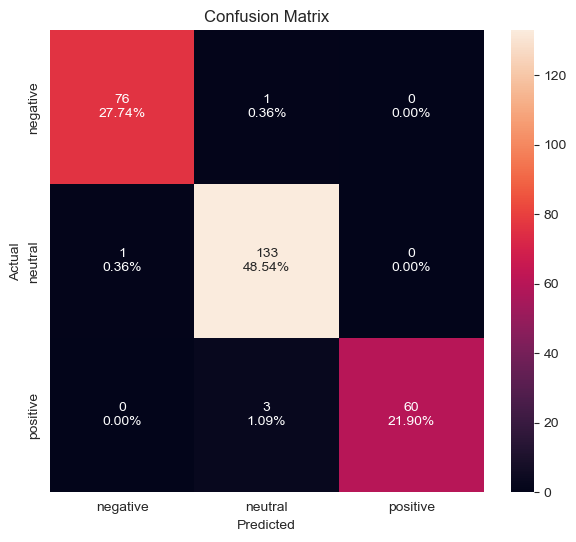

-------------------- Confusion Matrix ---- Validation set --------------------


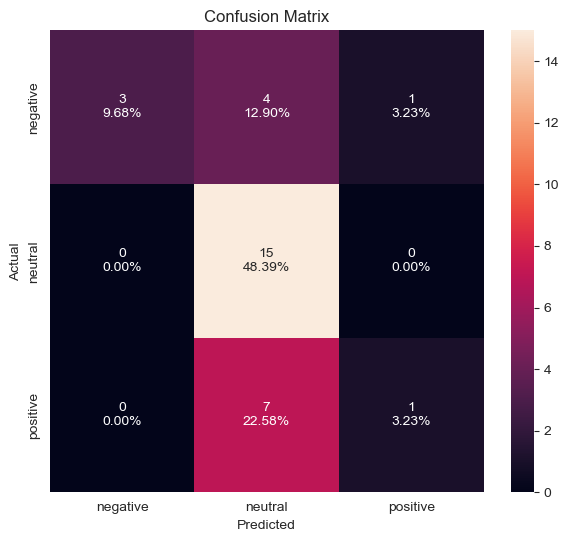

-------------------- classification report --------------------
            negative     neutral   positive  accuracy   macro avg  \
precision   0.987013    0.970803   1.000000  0.981752    0.985939   
recall      0.987013    0.992537   0.952381  0.981752    0.977310   
f1-score    0.987013    0.981550   0.975610  0.981752    0.981391   
support    77.000000  134.000000  63.000000  0.981752  274.000000   

           weighted avg  
precision      0.982072  
recall         0.981752  
f1-score       0.981719  
support      274.000000  
-------------------- classification report ---- Validation set --------------------
           negative    neutral  positive  accuracy  macro avg  weighted avg
precision  1.000000   0.576923     0.500  0.612903   0.692308      0.666253
recall     0.375000   1.000000     0.125  0.612903   0.500000      0.612903
f1-score   0.545455   0.731707     0.200  0.612903   0.492387      0.546427
support    8.000000  15.000000     8.000  0.612903  31.000000     31.000

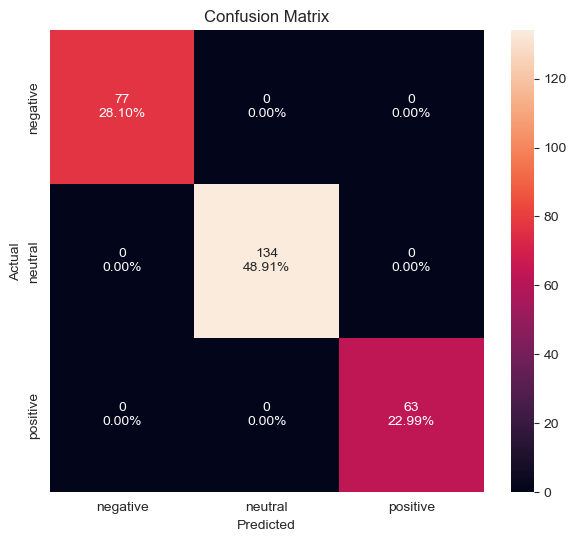

-------------------- Confusion Matrix ---- Validation set --------------------


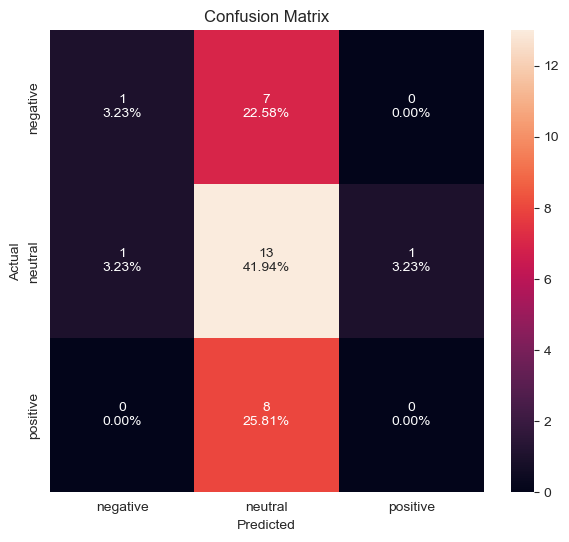

-------------------- classification report --------------------
           negative  neutral  positive  accuracy  macro avg  weighted avg
precision       1.0      1.0       1.0       1.0        1.0           1.0
recall          1.0      1.0       1.0       1.0        1.0           1.0
f1-score        1.0      1.0       1.0       1.0        1.0           1.0
support        77.0    134.0      63.0       1.0      274.0         274.0
-------------------- classification report ---- Validation set --------------------
           negative    neutral  positive  accuracy  macro avg  weighted avg
precision     0.500   0.464286       0.0  0.451613   0.321429      0.353687
recall        0.125   0.866667       0.0  0.451613   0.330556      0.451613
f1-score      0.200   0.604651       0.0  0.451613   0.268217      0.344186
support       8.000  15.000000       8.0  0.451613  31.000000     31.000000
Model: GBM
-------------------- Confusion Matrix --------------------


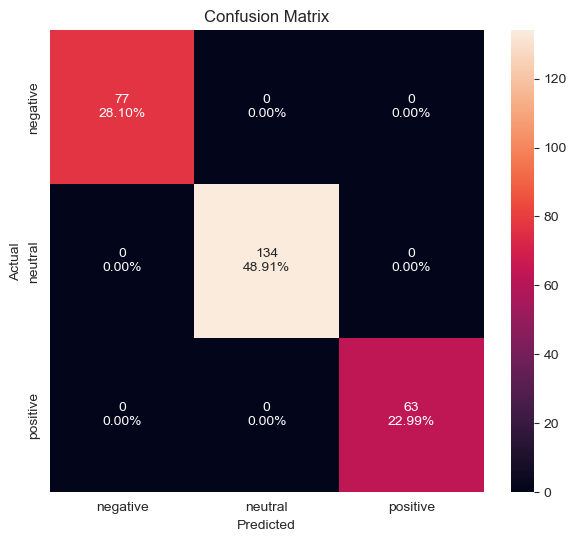

-------------------- Confusion Matrix ---- Validation set --------------------


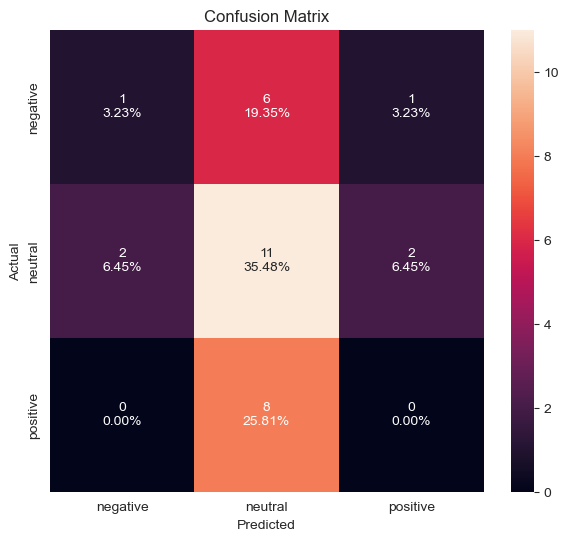

-------------------- classification report --------------------
           negative  neutral  positive  accuracy  macro avg  weighted avg
precision       1.0      1.0       1.0       1.0        1.0           1.0
recall          1.0      1.0       1.0       1.0        1.0           1.0
f1-score        1.0      1.0       1.0       1.0        1.0           1.0
support        77.0    134.0      63.0       1.0      274.0         274.0
-------------------- classification report ---- Validation set --------------------
           negative    neutral  positive  accuracy  macro avg  weighted avg
precision  0.333333   0.440000       0.0  0.387097   0.257778      0.298925
recall     0.125000   0.733333       0.0  0.387097   0.286111      0.387097
f1-score   0.181818   0.550000       0.0  0.387097   0.243939      0.313050
support    8.000000  15.000000       8.0  0.387097  31.000000     31.000000
Model: Adaboost
-------------------- Confusion Matrix --------------------


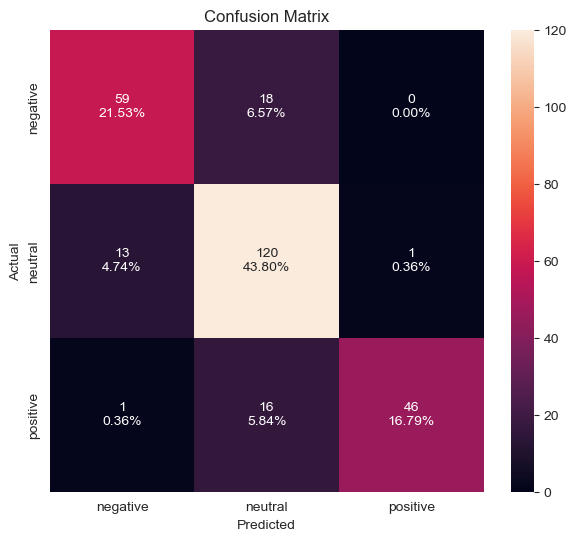

-------------------- Confusion Matrix ---- Validation set --------------------


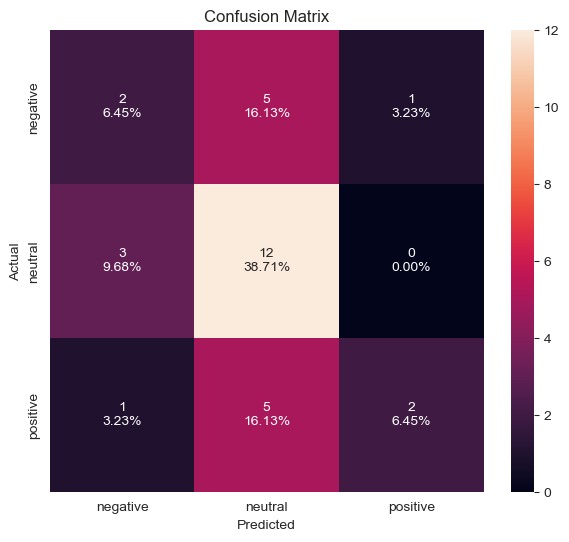

-------------------- classification report --------------------
            negative     neutral   positive  accuracy   macro avg  \
precision   0.808219    0.779221   0.978723  0.821168    0.855388   
recall      0.766234    0.895522   0.730159  0.821168    0.797305   
f1-score    0.786667    0.833333   0.836364  0.821168    0.818788   
support    77.000000  134.000000  63.000000  0.821168  274.000000   

           weighted avg  
precision      0.833241  
recall         0.821168  
f1-score       0.820916  
support      274.000000  
-------------------- classification report ---- Validation set --------------------
           negative    neutral  positive  accuracy  macro avg  weighted avg
precision  0.333333   0.545455  0.666667  0.516129   0.515152      0.521994
recall     0.250000   0.800000  0.250000  0.516129   0.433333      0.516129
f1-score   0.285714   0.648649  0.363636  0.516129   0.432666      0.481437
support    8.000000  15.000000  8.000000  0.516129  31.000000     31.000

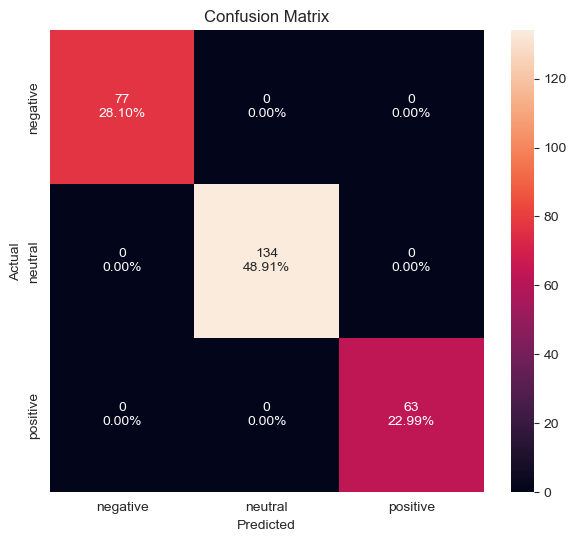

-------------------- Confusion Matrix ---- Validation set --------------------


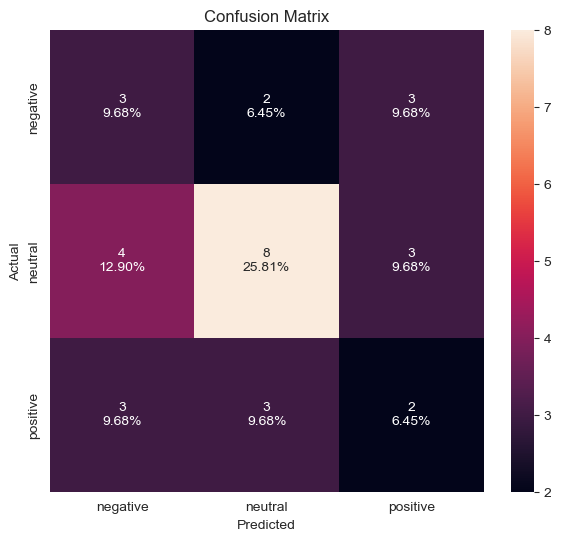

-------------------- classification report --------------------
           negative  neutral  positive  accuracy  macro avg  weighted avg
precision       1.0      1.0       1.0       1.0        1.0           1.0
recall          1.0      1.0       1.0       1.0        1.0           1.0
f1-score        1.0      1.0       1.0       1.0        1.0           1.0
support        77.0    134.0      63.0       1.0      274.0         274.0
-------------------- classification report ---- Validation set --------------------
           negative    neutral  positive  accuracy  macro avg  weighted avg
precision  0.300000   0.615385      0.25  0.419355   0.388462      0.439702
recall     0.375000   0.533333      0.25  0.419355   0.386111      0.419355
f1-score   0.333333   0.571429      0.25  0.419355   0.384921      0.427035
support    8.000000  15.000000      8.00  0.419355  31.000000     31.000000
Model: XGB
-------------------- Confusion Matrix --------------------


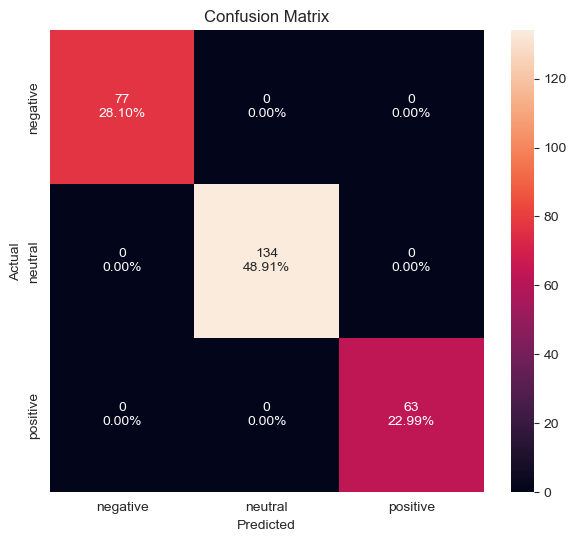

-------------------- Confusion Matrix ---- Validation set --------------------


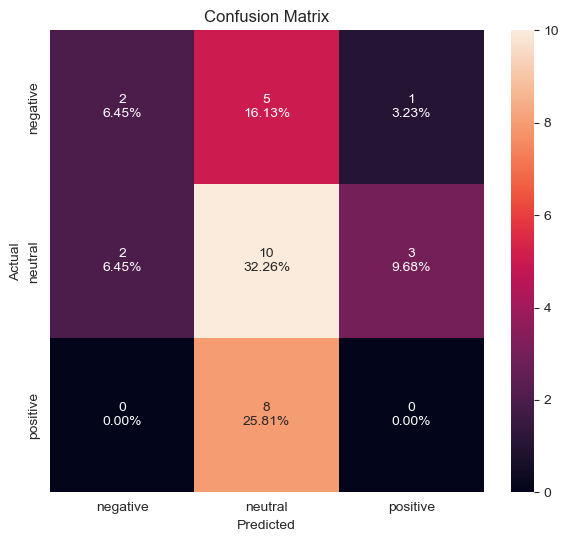

-------------------- classification report --------------------
           negative  neutral  positive  accuracy  macro avg  weighted avg
precision       1.0      1.0       1.0       1.0        1.0           1.0
recall          1.0      1.0       1.0       1.0        1.0           1.0
f1-score        1.0      1.0       1.0       1.0        1.0           1.0
support        77.0    134.0      63.0       1.0      274.0         274.0
-------------------- classification report ---- Validation set --------------------
           negative    neutral  positive  accuracy  macro avg  weighted avg
precision  0.500000   0.434783       0.0  0.387097   0.311594      0.339411
recall     0.250000   0.666667       0.0  0.387097   0.305556      0.387097
f1-score   0.333333   0.526316       0.0  0.387097   0.286550      0.340690
support    8.000000  15.000000       8.0  0.387097  31.000000     31.000000


In [304]:
result_base_st_model_training,  result_base_st_model_val = Apply_model(X_train_st, y_train, X_val_st, y_val)

In [305]:
result_base_st_model_training

[['Bagging',
              negative     neutral   positive  accuracy   macro avg  \
  precision   0.987013    0.970803   1.000000  0.981752    0.985939   
  recall      0.987013    0.992537   0.952381  0.981752    0.977310   
  f1-score    0.987013    0.981550   0.975610  0.981752    0.981391   
  support    77.000000  134.000000  63.000000  0.981752  274.000000   
  
             weighted avg  
  precision      0.982072  
  recall         0.981752  
  f1-score       0.981719  
  support      274.000000  ],
 ['Random forest',
             negative  neutral  positive  accuracy  macro avg  weighted avg
  precision       1.0      1.0       1.0       1.0        1.0           1.0
  recall          1.0      1.0       1.0       1.0        1.0           1.0
  f1-score        1.0      1.0       1.0       1.0        1.0           1.0
  support        77.0    134.0      63.0       1.0      274.0         274.0],
 ['GBM',
             negative  neutral  positive  accuracy  macro avg  weighted avg
 

In [306]:
result_base_st_model_val

[['Bagging',
             negative    neutral  positive  accuracy  macro avg  weighted avg
  precision  1.000000   0.576923     0.500  0.612903   0.692308      0.666253
  recall     0.375000   1.000000     0.125  0.612903   0.500000      0.612903
  f1-score   0.545455   0.731707     0.200  0.612903   0.492387      0.546427
  support    8.000000  15.000000     8.000  0.612903  31.000000     31.000000],
 ['Random forest',
             negative    neutral  positive  accuracy  macro avg  weighted avg
  precision     0.500   0.464286       0.0  0.451613   0.321429      0.353687
  recall        0.125   0.866667       0.0  0.451613   0.330556      0.451613
  f1-score      0.200   0.604651       0.0  0.451613   0.268217      0.344186
  support       8.000  15.000000       8.0  0.451613  31.000000     31.000000],
 ['GBM',
             negative    neutral  positive  accuracy  macro avg  weighted avg
  precision  0.333333   0.440000       0.0  0.387097   0.257778      0.298925
  recall     0.1250

### Models Tuned

In [310]:
tunning = []

# Appending model tuning into the list
tunning.append(("Bagging",
                BaggingClassifier(random_state=1),
                {
                    'max_samples': [0.8,0.9,1],
                    'max_features': [0.7,0.8,0.9],
                    'n_estimators' : [30,50,70],
                }
                ))
tunning.append(("Random forest",
                RandomForestClassifier(random_state=1, class_weight='balanced'),
                {
                    'n_estimators': [100, 200, 500],
                    'max_depth': [10, 20, 30, None],
                    'min_samples_split': [2, 5, 10],
                    'min_samples_leaf': [1, 2, 4],
                    'class_weight': [None, 'balanced', 'balanced_subsample'],
                    'bootstrap': [True, False]
                }
                ))
tunning.append(("GBM",
                GradientBoostingClassifier(random_state=1),
                {
                    "init": [AdaBoostClassifier(random_state=1),DecisionTreeClassifier(random_state=1)],
                    "n_estimators": np.arange(50,110,25),
                    "learning_rate": [0.01,0.1,0.05],
                    "subsample":[0.7,0.9],
                    "max_features":[0.5,0.7,1]
                }
                ))
tunning.append(("Adaboost",
                AdaBoostClassifier(random_state=1, algorithm='SAMME'),
                {
                    "n_estimators": np.arange(50,110,25),
                    "learning_rate": [0.01,0.1,0.05],
                    "base_estimator": [
                        DecisionTreeClassifier(max_depth=2, random_state=1),
                        DecisionTreeClassifier(max_depth=3, random_state=1),
                    ],
                }
                ))
tunning.append(("dtree",
                DecisionTreeClassifier(random_state=1, class_weight='balanced'),
                {
                    'max_depth': [5, 10, 15, None],
                    'min_samples_split': [2, 5, 10],
                    'min_samples_leaf': [1, 2, 4],
                    'criterion': ['gini', 'entropy'],
                    'max_features': ['auto', 'sqrt', 'log2', None]
                }
                ))
tunning.append(("XGB",
                XGBClassifier(random_state=1),
                {
                    'n_estimators': [100, 200, 500],
                    'learning_rate': [0.01, 0.05, 0.1, 0.2],
                    'max_depth': [3, 5, 7, 10],
                    'min_child_weight': [1, 3, 5],
                    'subsample': [0.6, 0.8, 1.0],
                    'colsample_bytree': [0.6, 0.8, 1.0],
                    'gamma': [0, 1, 5],
                    'reg_alpha': [0, 0.1, 0.5],
                    'reg_lambda': [0.1, 1, 10],
                }
                ))


In [330]:
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
)

def Find_best_model(X, y):
    result = []
    best_model_list = []
    scorer = metrics.make_scorer(metrics.f1_score, average='weighted')
    for name, model, hyper_para in tunning:
        randomize_cv = RandomizedSearchCV(estimator=model, param_distributions=hyper_para, cv=5, scoring=scorer)
        randomize_cv.fit(X, y)
        best_model = randomize_cv.best_estimator_
        best_model.fit(X, y)
        y_pred = best_model.predict(X)
        #preds_prob = best_model.predict_proba(X)[:, 1]
        #f1 = f1_score(Y, preds, average='weighted')
        #print(f"F1 score for {name} is {f1}")
        #print(f"Accuracy score for {name} is {accuracy_score(Y, preds)}")
        #print(f"Recall score for {name} is {recall_score(Y, preds, average='weighted')}")

        print('-'*20, f"classification report for: --->  {name}", '-'*20)
        res_dict = classification_report(y, y_pred, target_names=lable_name, output_dict=True)
        tmp_df = pd.DataFrame(res_dict)
        print(tmp_df.head())
        result.append([name, tmp_df])
        best_model_list.append([name, best_model])
    
    return result, best_model_list

In [333]:
def Model_tunned_val(model_tuned_list, X, y):
    result = []
    for name, model in model_tuned_list:
        y_pred = model.predict(X)
        print('-'*20, f"classification report on val for: --->  {name}", '-'*20)
        res_dict = classification_report(y, y_pred, target_names=lable_name, output_dict=True)
        tmp_df = pd.DataFrame(res_dict)
        print(tmp_df.head())
        result.append([name, tmp_df])
        
    return result

In [341]:
def Confusion_matrix_for_best_model(model_tuned_list, X, y, labels_name=None):
    for name, model in model_tuned_list:
        print('-'*20, f"Confusion Matrix for: --->  {name}", '-'*20)
        plot_confusion_matrix(model, X, y, labels_name=lable_name)

#### Turned Model - Word2Vec

In [331]:
result_tuned_wv_model_training, best_tuned_wv_training = Find_best_model(X_train_wv, y_train)

-------------------- classification report for: --->  Bagging --------------------
           negative     neutral   positive  accuracy   macro avg  weighted avg
precision       1.0    0.992593   1.000000   0.99635    0.997531      0.996377
recall          1.0    1.000000   0.984127   0.99635    0.994709      0.996350
f1-score        1.0    0.996283   0.992000   0.99635    0.996094      0.996343
support        77.0  134.000000  63.000000   0.99635  274.000000    274.000000
-------------------- classification report for: --->  Random forest --------------------
           negative  neutral  positive  accuracy  macro avg  weighted avg
precision       1.0      1.0       1.0       1.0        1.0           1.0
recall          1.0      1.0       1.0       1.0        1.0           1.0
f1-score        1.0      1.0       1.0       1.0        1.0           1.0
support        77.0    134.0      63.0       1.0      274.0         274.0
-------------------- classification report for: --->  GBM -----

In [334]:
result_tuned_wv_model_val = Model_tunned_val(best_tuned_wv_training, X_val_wv, y_val)

-------------------- classification report on val for: --->  Bagging --------------------
           negative    neutral  positive  accuracy  macro avg  weighted avg
precision  0.166667   0.391304       0.0  0.322581   0.185990      0.232352
recall     0.125000   0.600000       0.0  0.322581   0.241667      0.322581
f1-score   0.142857   0.473684       0.0  0.322581   0.205514      0.266068
support    8.000000  15.000000       8.0  0.322581  31.000000     31.000000
-------------------- classification report on val for: --->  Random forest --------------------
           negative    neutral  positive  accuracy  macro avg  weighted avg
precision  0.333333   0.500000       0.0  0.483871   0.277778      0.327957
recall     0.125000   0.933333       0.0  0.483871   0.352778      0.483871
f1-score   0.181818   0.651163       0.0  0.483871   0.277660      0.362000
support    8.000000  15.000000       8.0  0.483871  31.000000     31.000000
-------------------- classification report on val for:

-------------------- Confusion Matrix for: --->  Bagging --------------------


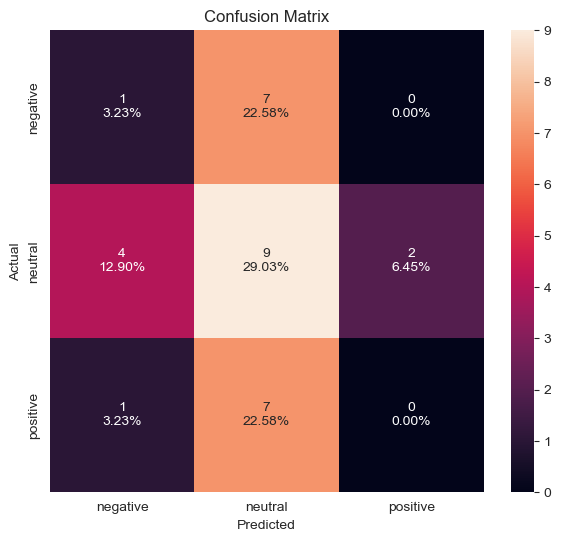

-------------------- Confusion Matrix for: --->  Random forest --------------------


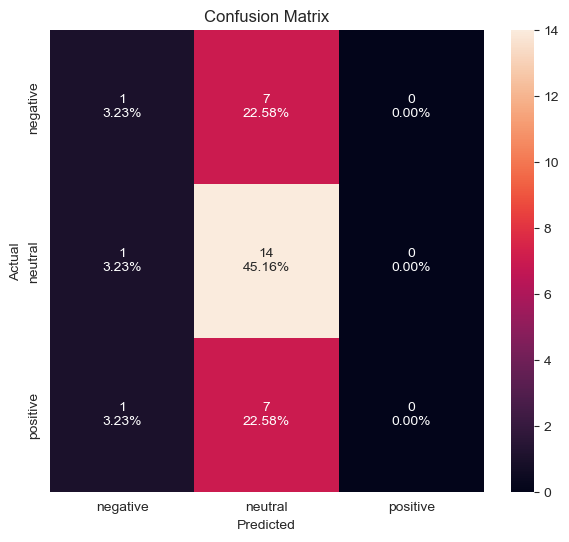

-------------------- Confusion Matrix for: --->  GBM --------------------


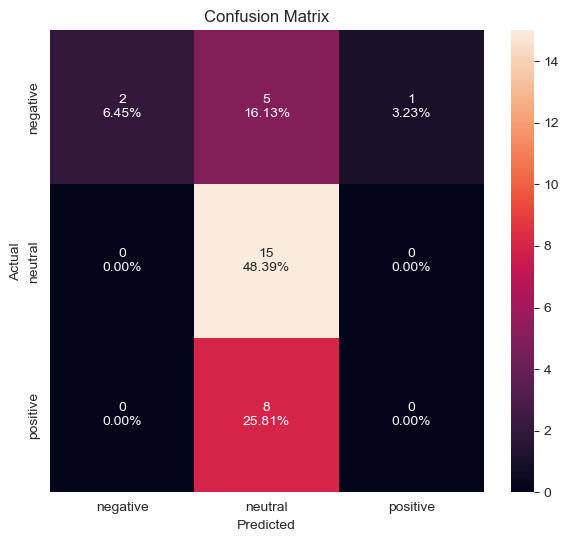

-------------------- Confusion Matrix for: --->  Adaboost --------------------


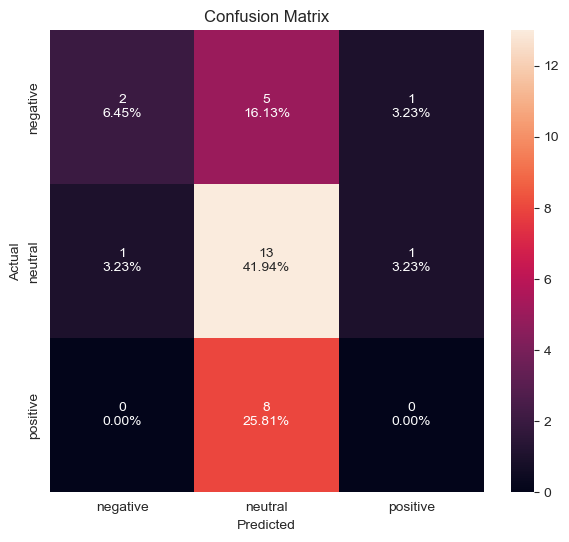

-------------------- Confusion Matrix for: --->  dtree --------------------


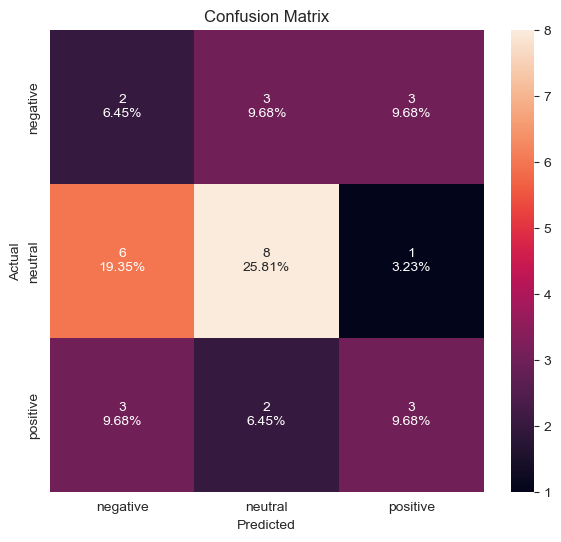

-------------------- Confusion Matrix for: --->  XGB --------------------


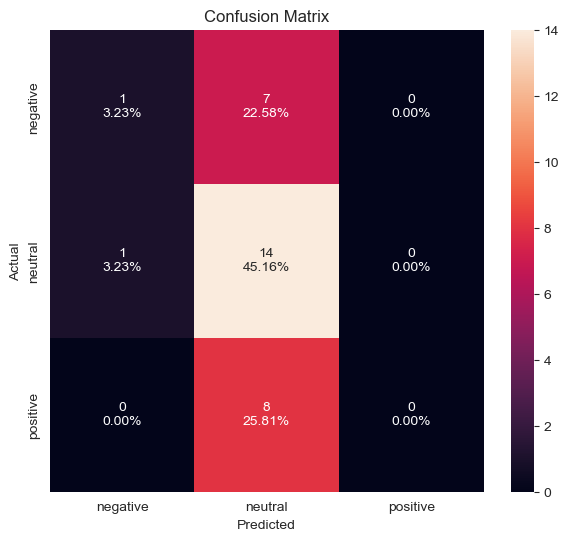

In [343]:
Confusion_matrix_for_best_model(best_tuned_wv_training, X_val_wv, y_val, labels_name=lable_name)

#### Turned Model - GloVe

In [335]:
result_tuned_gl_model_training, best_tuned_gl_training = Find_best_model(X_train_gl, y_train)

-------------------- classification report for: --->  Bagging --------------------
           negative  neutral  positive  accuracy  macro avg  weighted avg
precision       1.0      1.0       1.0       1.0        1.0           1.0
recall          1.0      1.0       1.0       1.0        1.0           1.0
f1-score        1.0      1.0       1.0       1.0        1.0           1.0
support        77.0    134.0      63.0       1.0      274.0         274.0
-------------------- classification report for: --->  Random forest --------------------
           negative  neutral  positive  accuracy  macro avg  weighted avg
precision       1.0      1.0       1.0       1.0        1.0           1.0
recall          1.0      1.0       1.0       1.0        1.0           1.0
f1-score        1.0      1.0       1.0       1.0        1.0           1.0
support        77.0    134.0      63.0       1.0      274.0         274.0
-------------------- classification report for: --->  GBM --------------------
         

In [336]:
result_tuned_gl_model_val = Model_tunned_val(best_tuned_gl_training, X_val_gl, y_val)

-------------------- classification report on val for: --->  Bagging --------------------
           negative    neutral  positive  accuracy  macro avg  weighted avg
precision  0.400000   0.541667      1.00  0.548387   0.647222      0.623387
recall     0.250000   0.866667      0.25  0.548387   0.455556      0.548387
f1-score   0.307692   0.666667      0.40  0.548387   0.458120      0.505211
support    8.000000  15.000000      8.00  0.548387  31.000000     31.000000
-------------------- classification report on val for: --->  Random forest --------------------
           negative    neutral  positive  accuracy  macro avg  weighted avg
precision  0.333333   0.444444       0.0  0.419355   0.259259      0.301075
recall     0.125000   0.800000       0.0  0.419355   0.308333      0.419355
f1-score   0.181818   0.571429       0.0  0.419355   0.251082      0.323419
support    8.000000  15.000000       8.0  0.419355  31.000000     31.000000
-------------------- classification report on val for:

-------------------- Confusion Matrix for: --->  Bagging --------------------


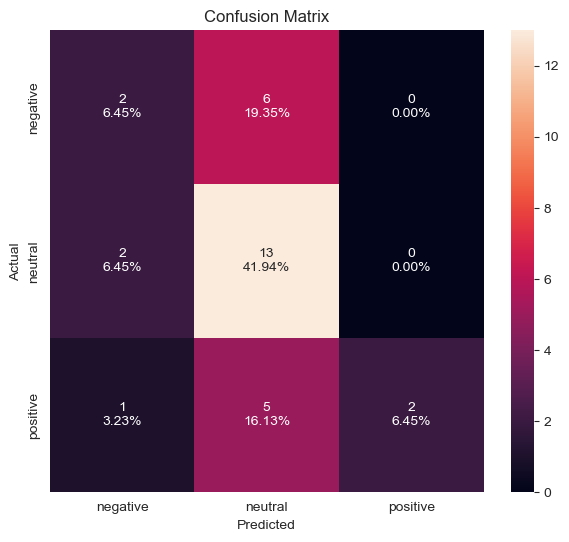

-------------------- Confusion Matrix for: --->  Random forest --------------------


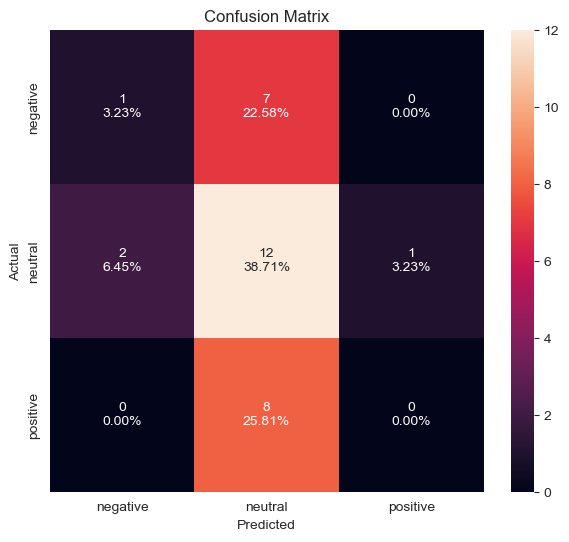

-------------------- Confusion Matrix for: --->  GBM --------------------


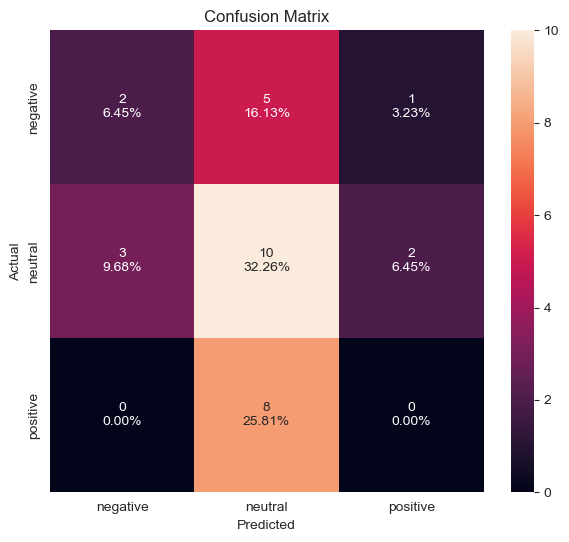

-------------------- Confusion Matrix for: --->  Adaboost --------------------


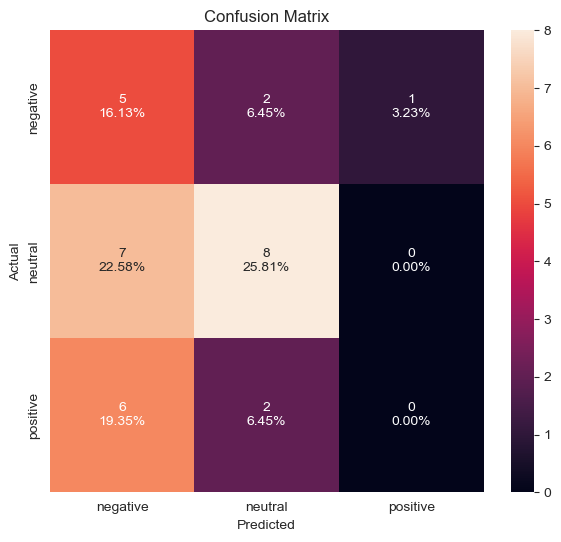

-------------------- Confusion Matrix for: --->  dtree --------------------


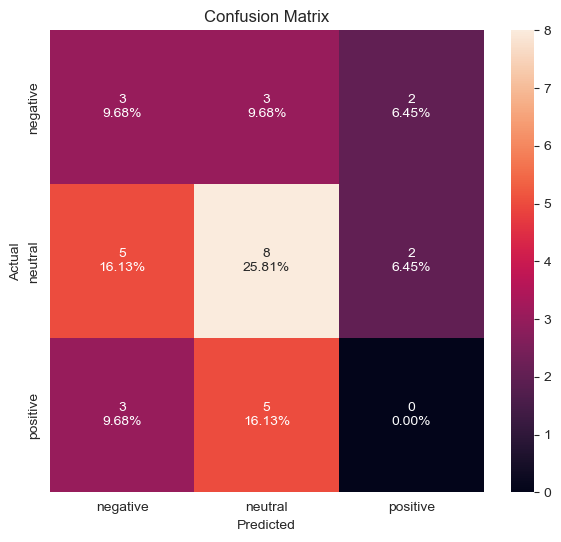

-------------------- Confusion Matrix for: --->  XGB --------------------


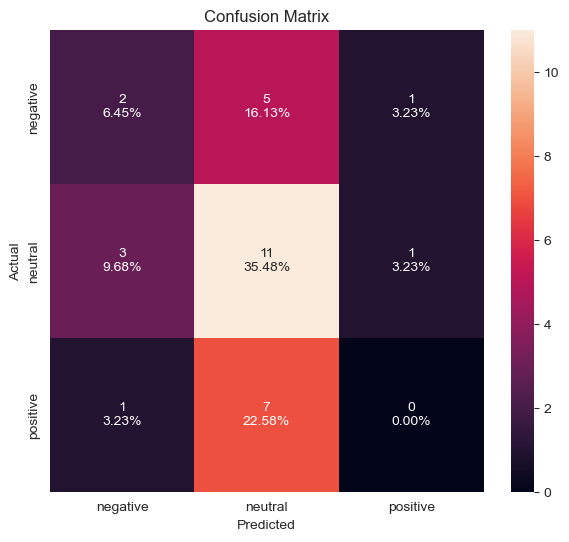

In [344]:
Confusion_matrix_for_best_model(best_tuned_gl_training, X_val_gl, y_val, labels_name=lable_name)

#### Tuned Model - Sentence Transformer

In [337]:
result_tuned_st_model_training, best_tuned_st_training = Find_best_model(X_train_st, y_train)


-------------------- classification report for: --->  Bagging --------------------
           negative  neutral  positive  accuracy  macro avg  weighted avg
precision       1.0      1.0       1.0       1.0        1.0           1.0
recall          1.0      1.0       1.0       1.0        1.0           1.0
f1-score        1.0      1.0       1.0       1.0        1.0           1.0
support        77.0    134.0      63.0       1.0      274.0         274.0
-------------------- classification report for: --->  Random forest --------------------
           negative  neutral  positive  accuracy  macro avg  weighted avg
precision       1.0      1.0       1.0       1.0        1.0           1.0
recall          1.0      1.0       1.0       1.0        1.0           1.0
f1-score        1.0      1.0       1.0       1.0        1.0           1.0
support        77.0    134.0      63.0       1.0      274.0         274.0
-------------------- classification report for: --->  GBM --------------------
         

In [338]:
result_tuned_st_model_val = Model_tunned_val(best_tuned_st_training, X_val_st, y_val)

-------------------- classification report on val for: --->  Bagging --------------------
           negative    neutral  positive  accuracy  macro avg  weighted avg
precision  0.666667   0.481481       0.0  0.483871   0.382716      0.405018
recall     0.250000   0.866667       0.0  0.483871   0.372222      0.483871
f1-score   0.363636   0.619048       0.0  0.483871   0.327561      0.393381
support    8.000000  15.000000       8.0  0.483871  31.000000     31.000000
-------------------- classification report on val for: --->  Random forest --------------------
           negative    neutral  positive  accuracy  macro avg  weighted avg
precision  0.500000   0.481481       0.0  0.483871   0.327160      0.362007
recall     0.250000   0.866667       0.0  0.483871   0.372222      0.483871
f1-score   0.333333   0.619048       0.0  0.483871   0.317460      0.385561
support    8.000000  15.000000       8.0  0.483871  31.000000     31.000000
-------------------- classification report on val for:

-------------------- Confusion Matrix for: --->  Bagging --------------------


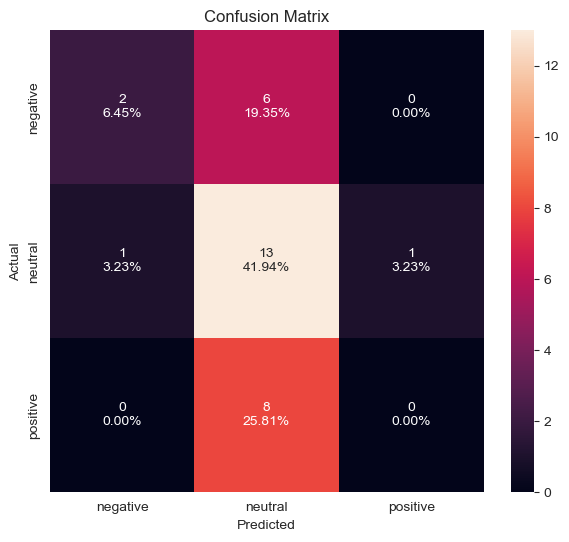

-------------------- Confusion Matrix for: --->  Random forest --------------------


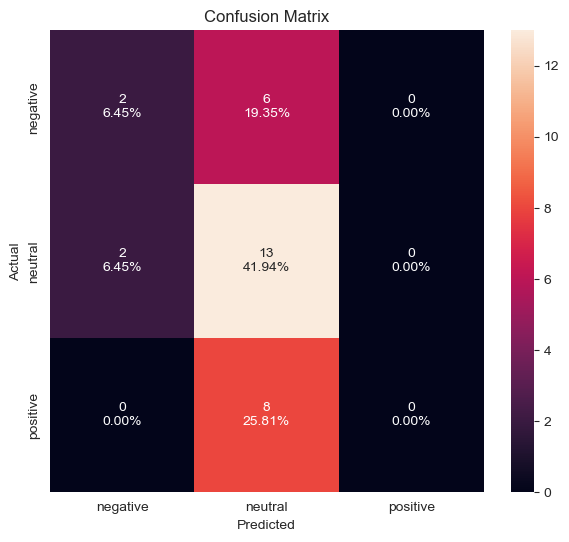

-------------------- Confusion Matrix for: --->  GBM --------------------


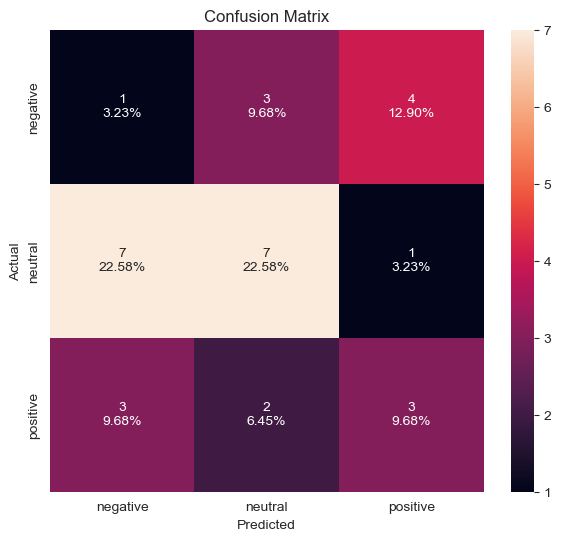

-------------------- Confusion Matrix for: --->  Adaboost --------------------


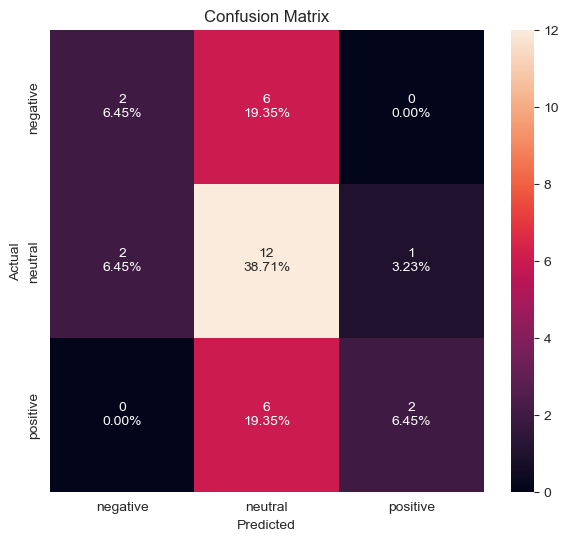

-------------------- Confusion Matrix for: --->  dtree --------------------


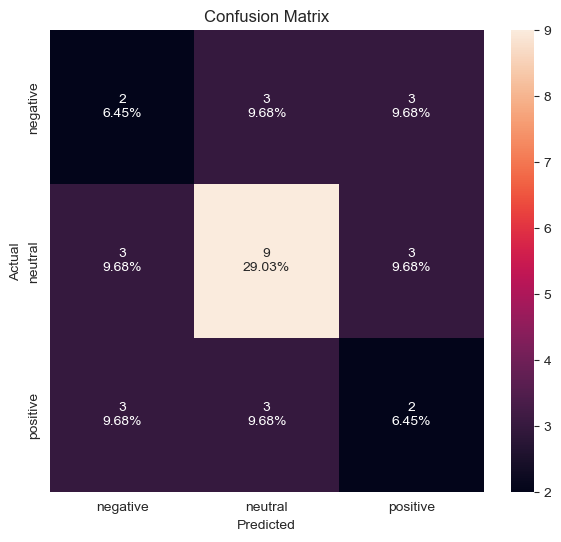

-------------------- Confusion Matrix for: --->  XGB --------------------


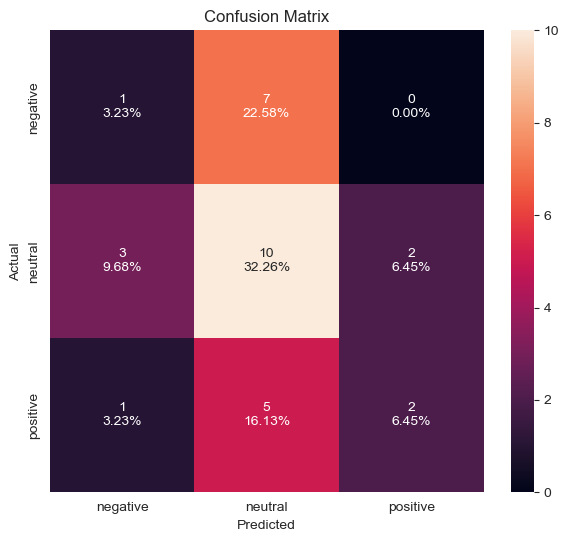

In [345]:
Confusion_matrix_for_best_model(best_tuned_st_training, X_val_st, y_val, labels_name=lable_name)

### Model Performance Summary and Final Model Selection


## Weekly News Summarization

**Important Note**: It is recommended to run this section of the project independently from the previous sections in order to avoid runtime crashes due to RAM overload.

#### Installing and Importing the necessary libraries

In [ ]:
# Installation for GPU llama-cpp-python
# uncomment and run the following code in case GPU is being used
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python -q

# Installation for CPU llama-cpp-python
# uncomment and run the following code in case GPU is not being used
#!CMAKE_ARGS="-DLLAMA_CUBLAS=off" FORCE_CMAKE=1 pip install llama-cpp-python -q

In [ ]:
# Function to download the model from the Hugging Face model hub
from huggingface_hub import hf_hub_download

# Importing the Llama class from the llama_cpp module
from llama_cpp import Llama

# Importing the library for data manipulation
import pandas as pd

from tqdm import tqdm # For progress bar related functionalities
tqdm.pandas()

#### Loading the data

#### Loading the model

#### Aggregating the data weekly

In [ ]:
data["Date"] = pd.to_datetime(data['Date'])  # Convert the 'Date' column to datetime format.

In [ ]:
# Group the data by week using the 'Date' column.
weekly_grouped = data.groupby(pd.Grouper(key='Date', freq='W'))

In [ ]:
weekly_grouped = weekly_grouped.agg(
    {
        'News': lambda x: ' || '.join(x)  # Join the news values with ' || ' separator.
    }
).reset_index()

print(weekly_grouped.shape)

In [ ]:
weekly_grouped

In [ ]:
# creating a copy of the data
data_1 = weekly_grouped.copy()

#### Summarization

**Note**:

- The model is expected to summarize the news from the week by identifying the top three positive and negative events that are most likely to impact the price of the stock.

- As an output, the model is expected to return a JSON containing two keys, one for Positive Events and one for Negative Events.

For the project, we need to define the prompt to be fed to the LLM to help it understand the task to perform. The following should be the components of the prompt:

1. **Role**: Specifies the role the LLM will be taking up to perform the specified task, along with any specific details regarding the role

  - **Example**: `You are an expert data analyst specializing in news content analysis.`

2. **Task**: Specifies the task to be performed and outlines what needs to be accomplished, clearly defining the objective

  - **Example**: `Analyze the provided news headline and return the main topics contained within it.`

3. **Instructions**: Provides detailed guidelines on how to perform the task, which includes steps, rules, and criteria to ensure the task is executed correctly

  - **Example**:

```
Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.
```

4. **Output Format**: Specifies the format in which the final response should be structured, ensuring consistency and clarity in the generated output

  - **Example**: `Return the output in JSON format with keys as the topic number and values as the actual topic.`

**Full Prompt Example**:

```
You are an expert data analyst specializing in news content analysis.

Task: Analyze the provided news headline and return the main topics contained within it.

Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.

Return the output in JSON format with keys as the topic number and values as the actual topic.
```

**Sample Output**:

`{"1": "Politics", "2": "Economy", "3": "Health" }`

##### Utility Functions

In [ ]:
# defining a function to parse the JSON output from the model
def extract_json_data(json_str):
    import json
    try:
        # Find the indices of the opening and closing curly braces
        json_start = json_str.find('{')
        json_end = json_str.rfind('}')

        if json_start != -1 and json_end != -1:
            extracted_category = json_str[json_start:json_end + 1]  # Extract the JSON object
            data_dict = json.loads(extracted_category)
            return data_dict
        else:
            print(f"Warning: JSON object not found in response: {json_str}")
            return {}
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e}")
        return {}

##### Defining the response function

In [ ]:
#Defining the response function
def response_mistral_1(prompt, news):
    model_output = llm(
      f"""
      [INST]
      {prompt}
      News Articles: {news}
      [/INST]
      """,
      max_tokens=_____, #Complete the code to set the maximum number of tokens the model should generate for this task.
      temperature=_____, #Complete the code to set the value for temperature.
      top_p=_____, #Complete the code to set the value for top_p
      top_k=_____, #Complete the code to set the value for top_k
      echo=False,
    )

    final_output = model_output["choices"][0]["text"]

    return final_output

##### Checking the model output on a sample

**Note**: Use this section to test out the prompt with one instance before using it for the entire weekly data.

##### Checking the model output on the weekly data

##### Formatting the model output

## **Conclusions and Recommendations**

-




<font size=6 color='blue'>Power Ahead</font>
___